### Imports and functions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from google.cloud import storage

# client = storage.Client()
# for blob in client.list_blobs('climateai_data_repository', prefix='tmp/internal_variability'):
#   print(str(blob))

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint
# from src.LE_LoadAndMerge import *
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from copy import deepcopy
from src.multi_model_large_ensemble import MultiModelLargeEnsemble
import matplotlib
matplotlib.rc_file_defaults()
import string

In [4]:
# def sensitivity_test(parameter,region,x_type,load,args):
#     values = args[parameter]
#     datasets = []
#     for i in values:
#         args[parameter] = i
#         internal = region.compute_x(x_type=x_type,load=load,**args)
#         datasets.append(internal)
#     dataset = xr.concat(datasets, dim=values)
#     # dataset['MTratio'] = dataset.model_le/dataset.total_le
        
#     return dataset

In [5]:
def sensitivity_test(parameter,region,x_type,load,args):
    values = args[parameter]
    datasets = []
    for i in values:
        args[parameter] = i
        region.compute_x(x_type=x_type,load=load,**args)
        region.compute_LE()
        region.compute_FIT()
        internal = region.results
        internal = internal.squeeze()
        datasets.append(internal)
    dataset = xr.concat(datasets, dim=values)
    dataset['MTratio'] = (dataset.M_LE/(dataset.M_LE+dataset.Ibar_LE))*100
        
    return dataset

In [11]:
def merge_region_variable(ds1,ds2):
    regions = ['Seattle', 'Sydney', 'Lagos']
    lats = [47.6, -33.8, 6.5]
    lons = [237.7, 151.2, 3.4]
    region_dim = xr.DataArray(regions, coords={'region': regions})

    variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')
    
    dataset = xr.concat([ds.sel(
        lat=xr.DataArray(lats, coords={'region': region_dim}), 
        lon=xr.DataArray(lons, coords={'region': region_dim}), 
        method='nearest'
    ) for ds in [ds1, ds2]], dim=variable_dim)
    
    return dataset 

In [7]:
# def extreme_internal_allregions(x_type,load,name,args):
#     regions = [USwest,europe,australia,tropics]
#     dss = []
#     for region in regions:
#         region.compute_x(x_type=x_type,load=load,**args)
#         region.compute_LE()
#         region.compute_FIT()
#         internal = region.results
#         internal = internal.squeeze()
#         datasets.append(internal)
#         internal = internal.expand_dims('region')
#         dss.append(internal)
#     regions = ['USwest','europe','australia','tropics']
#     final_dataset = xr.concat(dss,dim='region')
#     final_dataset = final_dataset.assign_coords({'region':regions})
#     return final_dataset

In [21]:
def sensitivity_allregions(parameter,regions,x_type,load,args):
    regions = regions
    dss = []
    for r in regions:
        tmp_args = deepcopy(args)
        ds = sensitivity_test(parameter=parameter,region=r,x_type=x_type,load=load,args=tmp_args)
        ds = ds.expand_dims('region')
        dss.append(ds)
    regions = ['Seattle','Sydney','Lagos']
    final_dataset = xr.concat(dss,dim='region')
    final_dataset = final_dataset.assign_coords({'region':regions})
    
    return final_dataset

In [8]:
# sensitivity_test(parameter='return_period',
#                  region=USwest,
#                  x_type = 'quantile_return',
#                  load=False,
#                  name='USwest_test_return',
#                  args={'return_period':[5,10,20,50,100],
#                             'coarsen':1,
#                             'consec_days':1,
#                             'rolling_average':10,
#                             'hist_slice':slice('1995','2014')
#                       }
#                 )

In [9]:
# def extreme_internal_allregions(args):
#     regions = [USwest,europe,australia,tropics]
#     dss = []
#     for r in regions:
#         internal = r.extreme_internal_variability(**args)
#         internal = internal.expand_dims('region')
#         dss.append(internal)
#     regions = ['USwest','europe','australia','tropics']
#     final_dataset = xr.concat(dss,dim='region')
#     final_dataset = final_dataset.assign_coords({'region':regions})
#     return final_dataset

## Global code 

In [6]:
-53.1 % 360

306.9

In [9]:
# load global data 
tas_mmle = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [10]:
# load global data 
pr_mmle = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'pr', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [13]:
%%time
tas_testreturn = sensitivity_test(parameter='return_period',
                 region=tas_mmle,
                 x_type='quantile_return',
                 load=False,
                 args = {'return_period':[5,10,20,50,100],
                            'coarsen':1,
                            'consec_days':1,
                            'rolling_average':10,
                            'hist_slice':slice('1995','2014')
                            })

  0%|          | 0/120 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
pr_testreturn = sensitivity_test(parameter='return_period',
                 region=pr_mmle,
                 x_type='quantile_return',
                 load=True,
                 name='pr_default_quantile_return_10yr',
                 args = {'return_period':[5,10,20,50,100],
                            'coarsen':1,
                            'consec_days':1,
                            'rolling_average':10,
                            'hist_slice':slice('1995','2014')
                            })

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/CanESM5.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/EC-Earth3.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/CanESM5.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/MPI-ESM1-2-LR.zarr
Loa

In [ ]:
# def sensitivity_test(parameter,dataset,x_type,load,name,args):
#     values = args[parameter]
#     datasets = []
#     for i in values:
#         args[parameter] = i
#         dataset.compute_x(x_type=x_type,load=load,name=name,**args)
#         dataset.compute_LE()
#         dataset.compute_FIT()
#         internal = dataset.results
#         internal = internal.squeeze()
#         datasets.append(internal)
#     dataset = xr.concat(datasets, dim=values)
#     dataset['MTratio'] = (dataset.M_LE/(dataset.M_LE+dataset.Ibar_LE))*100
        
#     return dataset

In [ ]:
# def sensitivity_allregions(parameter,datasets,x_type,load,names,args):
#     regions = ['region1', 'region2', 'region3']
#     lats = [51, 3.9, -25.2]
#     lons = [10.5, 306.9, 133.7]
#     region_dim = xr.DataArray(regions, coords={'region': regions})
#     variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')

#     tmp_args = deepcopy(args)
    
#     tas_ds = sensitivity_test(parameter=parameter,dataset=datasets[0],x_type=x_type,load=load,name=names[0],args=tmp_args)
#     pr_ds = sensitivity_test(parameter=parameter,dataset=datasets[1],x_type=x_type,load=load,name=names[1],args=tmp_args)
    
#     final_dataset = xr.concat([ds.sel(
#         lat=xr.DataArray(lats, coords={'region': region_dim}), 
#         lon=xr.DataArray(lons, coords={'region': region_dim}), 
#     method='nearest'
#     ) for ds in [tas_ds, pr_ds]], dim=variable_dim)
    
#     # for d,n in zip(datasets,names):
#     #     tmp_args = deepcopy(args)
#     #     ds = sensitivity_test(parameter=parameter,region=d,x_type=x_type,load=load,name=n,args=tmp_args)
#     #     ds = ds.expand_dims('region')
#     #     dss.append(ds)
#     # regions = ['USwest','europe','australia','tropics']
#     # final_dataset = xr.concat(dss,dim='region')
#     # final_dataset = final_dataset.assign_coords({'region':regions})
    
#     return final_dataset

In [40]:
# test = sensitivity_allregions(parameter='return_period',
#                               datasets=[tas_mmle,pr_mmle],
#                               x_type='quantile_return',
#                               load=True,
#                               names=['tasmax_default_quantile_return_10yr','pr_default_quantile_return_10yr'],
#                               args={'return_period':[5,10,20,50,100],
#                                     'coarsen':1,
#                                     'consec_days':1,
#                                     'rolling_average':10,
#                                     'hist_slice':slice('1995','2014')
#                             })

In [27]:
test_return = merge_region_variable(tas_testreturn,pr_testreturn)

In [28]:
test_return = test_return.load()

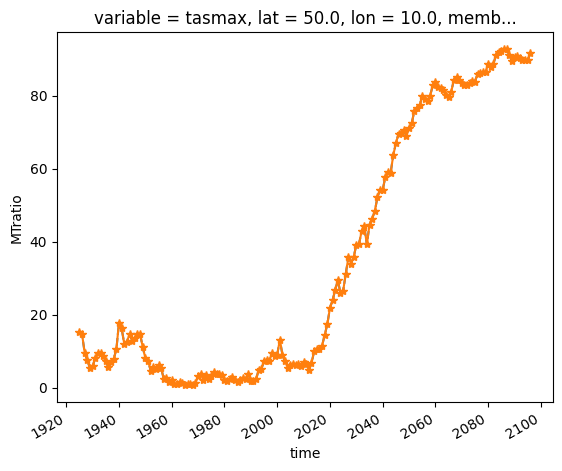

In [31]:
# for i in range(len(test_return.concat_dim)):
test_return.isel(variable=0, region=0, concat_dim=0).MTratio.plot(linestyle='dashed')
test_return.isel(variable=0, region=0, concat_dim=1).MTratio.plot(marker='*')

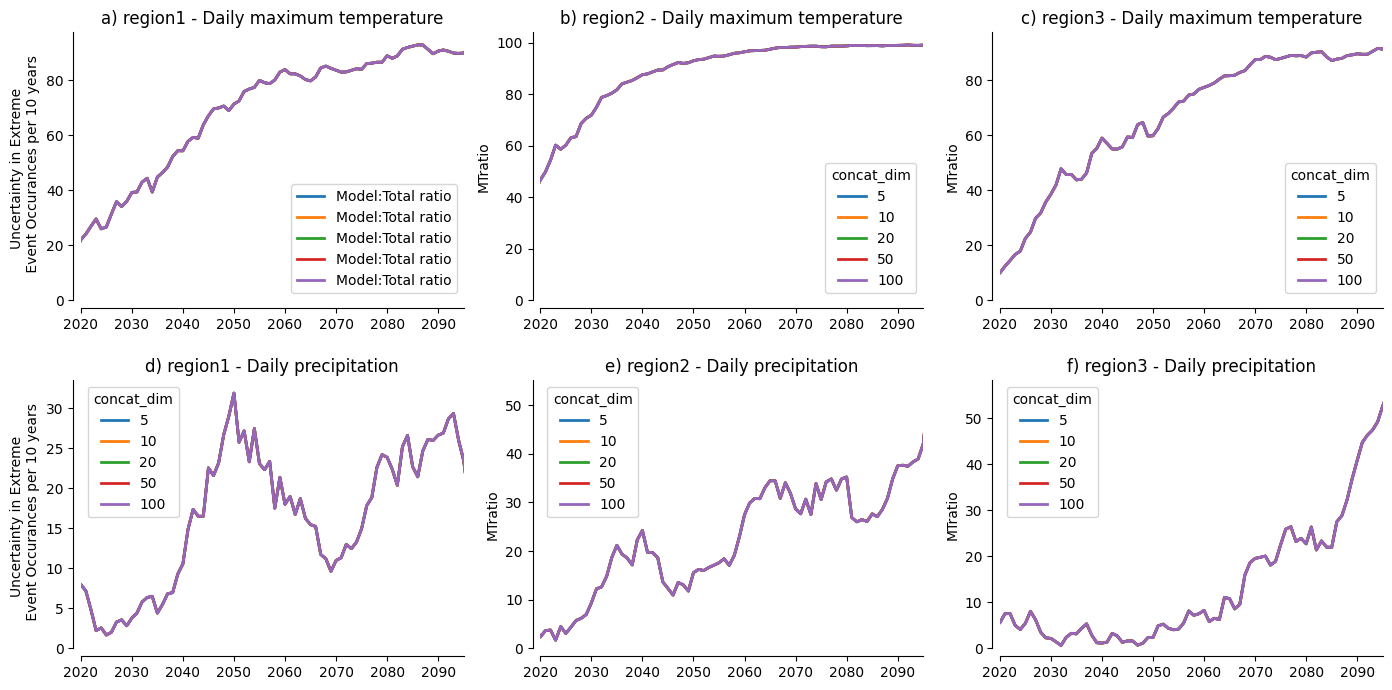

In [50]:
colors = ['k','b','g','r','orange']
var_dict = {'tasmax': 'Daily maximum temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_return['variable'].values):
    for ir, r in enumerate(test_return.region.values):
        ax = axs[iv, ir]
        # for im, m in enumerate(internal.model.values):
        test_return.sel(variable=v, region=r).MTratio.plot(hue='concat_dim',ax=ax, lw=2,label='Model:Total ratio')
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
axs[0, 0].legend()
for ax in axs[:, 0]:
    ax.set_ylabel('Uncertainty in Extreme \n Event Occurances per 10 years')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
# fig.savefig('./plots/std_uncertainties_noscenario.png', dpi=200)

## Sensitivity plots for paper

#### Get Data 

In [14]:
# setting 
# variable = 'tas'
# variable = 'tasmax'
# variable = 'pr'
models = ['MIROC6', 'CanESM5', 'MPI-ESM1-2-LR', 'EC-Earth3','cesm_lens']

In [ ]:
regions = ['Seattle', 'Sydney', 'Lagos']
lats = [47.6, -33.8, 6.5]
lons = [237.7, 151.2, 3.4]
region_dim = xr.DataArray(regions, coords={'region': regions})

In [33]:
# USwest = MultiModelLargeEnsemble(models=models, variable=variable, granularity='day', 
#                                lat=37.7, lon=237.6, 
#                                bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [15]:
seattle_pr = MultiModelLargeEnsemble(models=models, variable='pr', granularity='day', 
                               lat=47.6, lon=237.7, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [17]:
sydney_pr = MultiModelLargeEnsemble(models=models, variable='pr', granularity='day', 
                               lat=-33.8, lon=151.2, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [19]:
lagos_pr = MultiModelLargeEnsemble(models=models, variable='pr', granularity='day', 
                               lat=6.5, lon=3.4, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [16]:
seattle_tas = MultiModelLargeEnsemble(models=models, variable='tas', granularity='day', 
                               lat=47.6, lon=237.7, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [18]:
sydney_tas = MultiModelLargeEnsemble(models=models, variable='tas', granularity='day', 
                               lat=-33.8, lon=151.2, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [20]:
lagos_tas = MultiModelLargeEnsemble(models=models, variable='tas', granularity='day', 
                               lat=6.5, lon=3.4, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

#### Test_return

In [22]:
test_return_pr = sensitivity_allregions(parameter='return_period',
                                     regions=[seattle_pr,sydney_pr,lagos_pr],
                 x_type='quantile_return',
                 load=False,
                 args = {'return_period':[5,10,20,50,100],
                            'coarsen':1,
                            'consec_days':1,
                            'rolling_average':10,
                            'hist_slice':slice('1995','2014')
                            })


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


44.30241012573242



100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


44.315372467041016



100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


44.3144645690918



100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


44.23854064941406



100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


44.23963165283203



100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


44.25817108154297



100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


44.25603485107422



100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


44.25590515136719



100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


44.254024505615234



100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


44.26218032836914



100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


44.2660026550293



100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


44.265071868896484



100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


44.2725944519043



100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


44.26856231689453



100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


44.27726745605469



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


44.269771575927734



100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


44.271724700927734



100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


44.28167724609375



100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


44.287994384765625



100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


44.29298782348633



100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


44.295692443847656



100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


44.28723907470703



100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


44.293113708496094



100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


44.28636932373047



100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


44.29071044921875



100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


44.2940673828125



100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


44.298126220703125



100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


44.29805374145508



100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


44.29912185668945



100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


44.29157638549805



100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


44.29217529296875



100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


44.29625701904297



100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


44.295013427734375



100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


44.29487609863281



100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


44.2962646484375



100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


44.30668258666992



100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


44.30800247192383



100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


44.301151275634766



100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


44.305355072021484



100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


44.305789947509766



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


44.30534744262695



100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


44.30156707763672



100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


44.304969787597656



100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


44.307472229003906



100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


44.30998229980469



100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


44.302284240722656



100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


44.307838439941406



100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


44.30297088623047



100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


44.3070068359375



100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


44.29966735839844



100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


44.298614501953125



100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


44.30097961425781



100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


44.298362731933594



100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


44.30023956298828



100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


44.306129455566406



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


44.30636978149414



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


44.30965805053711



100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


44.3078498840332



100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


44.303157806396484



100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


44.30134582519531



100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


44.30979919433594



100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


44.31310272216797



100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


44.310760498046875



100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


44.315574645996094



100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


44.306640625



100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


44.309608459472656



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


44.307159423828125



100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


44.30665588378906



100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


44.308349609375



100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


44.31055450439453



100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


44.310882568359375



100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


44.31915283203125



100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


44.310447692871094



100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


44.30766296386719



100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

44.31578063964844


In [23]:
test_return_tas = sensitivity_allregions(parameter='return_period',
                                     regions=[seattle_tas,sydney_tas,lagos_tas],
                 x_type='quantile_return',
                 load=False,
                 args = {'return_period':[5,10,20,50,100],
                            'coarsen':1,
                            'consec_days':1,
                            'rolling_average':10,
                            'hist_slice':slice('1995','2014')
                            })


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


44.31561279296875



100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


44.30729675292969



100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


44.31224060058594



100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


44.32394790649414



100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


44.31074142456055



100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


44.317508697509766



100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


44.317745208740234



100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


44.315677642822266



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


44.31993865966797



100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


44.3173713684082



100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


44.31991958618164



100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


44.31784439086914



100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


44.3149528503418



100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


44.31476974487305



100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


44.3137321472168



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


44.3206672668457



100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


44.326786041259766



100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


44.318172454833984



100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


44.32285690307617



100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


44.313655853271484



100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


44.31547164916992



100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


44.31998825073242



100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


44.31916427612305



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


44.319889068603516



100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


44.3181266784668



100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


44.31740951538086



100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


44.32113265991211



100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


44.32040786743164



100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


44.32295608520508



100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


44.320491790771484



100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


44.32684326171875



100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


44.325828552246094



100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


44.325439453125



100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


44.32456970214844



100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


44.32688522338867



100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


44.32236099243164



100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


44.3281135559082



100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


44.32730484008789



100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


44.32929611206055



100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


44.332427978515625



100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


44.31706619262695



100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


44.315433502197266



100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


44.3140754699707



100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


44.3166618347168



100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


44.31328201293945



100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


44.32621765136719



100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


44.32539367675781



100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


44.32464599609375



100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


44.32275390625



100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


44.31667709350586



100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


44.327022552490234



100%|██████████| 1/1 [00:05<00:00,  5.83s/it]


44.322715759277344



100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


44.32970428466797



100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


44.33203125



100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


44.32235336303711



100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


44.31949234008789



100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


44.32721710205078



100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


44.32115936279297



100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


44.321205139160156



100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


44.31965637207031



100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


44.33253479003906



100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


44.32586669921875



100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


44.327667236328125



100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


44.31995391845703



100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


44.322425842285156



100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


44.33148193359375



100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


44.33254623413086



100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


44.32139205932617



100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


44.32881546020508



100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


44.328697204589844



100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


44.32537841796875



100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


44.32292175292969



100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


44.32615661621094



100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


44.326873779296875



100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

44.322715759277344


In [24]:
variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')
    
test_return = xr.concat([test_return_tas,test_return_pr], dim=variable_dim)

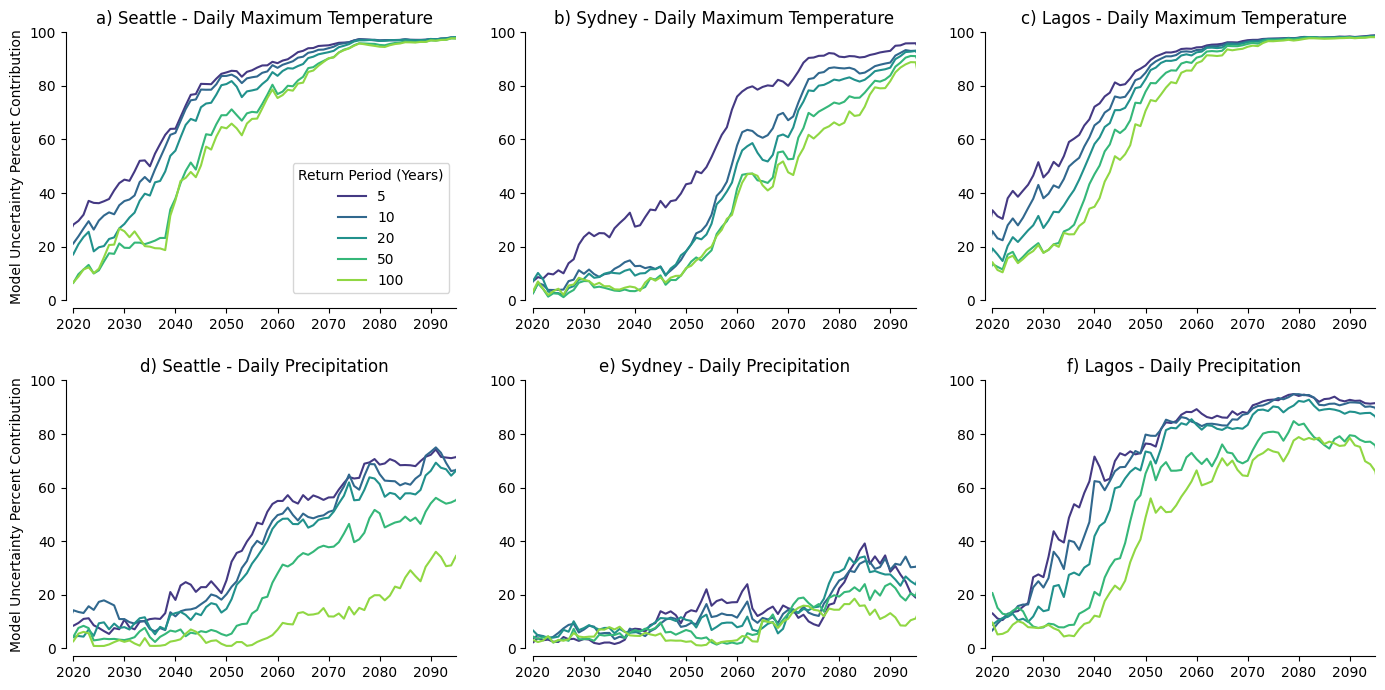

In [27]:
colors = sns.color_palette("viridis", len(test_return.concat_dim))
var_dict = {'tasmax': 'Daily Maximum Temperature', 'pr': 'Daily Precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_return['variable'].values):
    for ir, r in enumerate(test_return.region.values):
        ax = axs[iv, ir]
        for im,m in enumerate(test_return.concat_dim.values):
            ax.plot(test_return.sel(variable=v,region=r,concat_dim=m).time,test_return.sel(variable=v,region=r,concat_dim=m).MTratio,c=colors[im])
            # test_return.sel(variable=v, region=r).MTratio.plot(ax=ax,c=colors[im],hue='concat_dim', lw=2,label='Model:Total ratio',add_legend=False)
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
labels=['5','10','20','50','100']
axs[0, 0].legend(labels=labels,title='Return Period (Years)')
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')
for ax in axs[0,:]:
    ax.set_ylim(bottom=0,top=100)
for ax in axs[1,:]:
    ax.set_ylim(bottom=0,top=100)
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/sensitivity_testreturn.png', dpi=200)

#### Hist slice

In [93]:
test_histslice_pr = sensitivity_allregions(parameter='hist_slice',
                                        regions=[europe_pr,australia_pr,tropics_pr],
                                        x_type = 'quantile_return',
                                        load=False,
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'consec_days':1,
                                                'rolling_average':10,
                                                'hist_slice':[slice('1980','2000'),
                                                              slice('1990','2010'),slice('1995','2014'),
                                                              slice(None, None), slice('1990', None)]
                                               }
                                       )

100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


43.495567321777344


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


43.499839782714844


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


43.494895935058594


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


43.49604797363281


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


43.49299621582031


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


43.499534606933594


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


43.496055603027344


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


43.48876190185547


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


43.496498107910156


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


43.4984130859375


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


43.497711181640625


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


43.49108123779297


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


43.48831558227539


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


43.490882873535156


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


43.490867614746094


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


43.506771087646484


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


43.500240325927734


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


43.502193450927734


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


43.498050689697266


100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


43.49942398071289


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


43.50468063354492


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


43.50578689575195


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


43.50534439086914


100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


43.50114059448242


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


43.5012092590332


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


43.507625579833984


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


43.50717544555664


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


43.5085334777832


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


43.50553512573242


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


43.503292083740234


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


43.50957107543945


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


43.50802230834961


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


43.51580810546875


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


43.507232666015625


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


43.50659942626953


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


43.50447082519531


100%|██████████| 1/1 [00:03<00:00,  3.42s/it]


43.486602783203125


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


43.490447998046875


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


43.49354553222656


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


43.49663543701172


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


43.49140167236328


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


43.49591827392578


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


43.49089050292969


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


43.48646926879883


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


43.4940299987793


100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


43.49288558959961


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


43.49153518676758


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


43.4868278503418


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.498291015625


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


43.489845275878906


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


43.48564910888672


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


43.492889404296875


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


43.486656188964844


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


43.4886474609375


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


43.48809814453125


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


43.492591857910156


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


43.48925018310547


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


43.49895477294922


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


43.485870361328125


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


43.4912109375


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


43.48916244506836


100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


43.48597717285156


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


43.48873519897461


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


43.49506378173828


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


43.49443054199219


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


43.49371337890625


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


43.49542999267578


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


43.498008728027344


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


43.495384216308594


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


43.494873046875


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


43.49029541015625


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


43.5010986328125


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


43.494140625


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


43.49419403076172


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

43.49623107910156


In [94]:
test_histslice_tas = sensitivity_allregions(parameter='hist_slice',
                                        regions=[europe_tas,australia_tas,tropics_tas],
                                        x_type = 'quantile_return',
                                        load=False,
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'consec_days':1,
                                                'rolling_average':10,
                                                'hist_slice':[slice('1980','2000'),
                                                              slice('1990','2010'),slice('1995','2014'),
                                                              slice(None, None), slice('1990', None)]
                                               }
                                       )

100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.487613677978516


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


43.492008209228516


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


43.49648666381836


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


43.4976806640625


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


43.49931335449219


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


43.49424743652344


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


43.493980407714844


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


43.498870849609375


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


43.48797607421875


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


43.493011474609375


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


43.490386962890625


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


43.49718475341797


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


43.488059997558594


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


43.49236297607422


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


43.49052429199219


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


43.495689392089844


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.498252868652344


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


43.489295959472656


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


43.494422912597656


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


43.49809265136719


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


43.48759460449219


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


43.48970413208008


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


43.49335479736328


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


43.497310638427734


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


43.49204635620117


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.48992156982422


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.490318298339844


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


43.489776611328125


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


43.49394226074219


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


43.489227294921875


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


43.493011474609375


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


43.49131774902344


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


43.49070739746094


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


43.48875427246094


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


43.49186706542969


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


43.489437103271484


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


43.49137496948242


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


43.49692916870117


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


43.485252380371094


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


43.49052810668945


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


43.49135208129883


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


43.493831634521484


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


43.49325180053711


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


43.49077224731445


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


43.49051284790039


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


43.4970817565918


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


43.4931526184082


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


43.4910774230957


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


43.49101638793945


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


43.487491607666016


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


43.48861312866211


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


43.49637222290039


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


43.48923873901367


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


43.49325180053711


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


43.48691177368164


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


43.487789154052734


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


43.500701904296875


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


43.49015426635742


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


43.4957389831543


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


43.49274826049805


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


43.49241256713867


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


43.487613677978516


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


43.494991302490234


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


43.4929313659668


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


43.49374771118164


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


43.49514389038086


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


43.489749908447266


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


43.49013137817383


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


43.495723724365234


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


43.49361038208008


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


43.49717330932617


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


43.496891021728516


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


43.49795150756836


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


43.49160385131836


100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

43.49677276611328


In [95]:
variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')
    
test_histslice = xr.concat([test_histslice_tas,test_histslice_pr], dim=variable_dim)

In [97]:
test_histslice

<xarray.Dataset>
Dimensions:     (variable: 2, time: 106, region: 3, concat_dim: 5, model: 5)
Coordinates:
  * variable    (variable) <U6 'tasmax' 'pr'
  * time        (time) datetime64[ns] 1995-01-01 1996-01-01 ... 2100-01-01
    lat         (region) float64 50.0 -25.0 5.0
    lon         (region) float64 10.0 132.5 307.5
  * model       (model) <U13 'MIROC6' 'CanESM5' ... 'EC-Earth3' 'cesm_lens'
    quantile    (model) float64 0.9995 0.9995 0.9995 0.9995 0.9995
    q_values    (variable, region, model) float64 301.7 298.2 ... 0.0003968
    member_id   int64 1
  * concat_dim  (concat_dim) object slice('1980', '2000', None) ... slice('19...
  * region      (region) <U7 'region1' 'region2' 'region3'
Data variables:
    M_LE        (variable, region, concat_dim, time) float64 0.08736 ... nan
    I_LE        (variable, region, concat_dim, model, time) float64 4.002 ......
    Ibar_LE     (variable, region, concat_dim, time) float64 4.941 4.962 ... nan
    T_LE        (variable, region, concat_dim, time) float64 3.216 3.198 ... nan
    FIT         (variable, region, concat_dim, time, model) float64 2.544 ......
    M_FIT       (variable, region, concat_dim, time) float64 24.63 ... 4.248
    I_FIT       (variable, region, concat_dim, model) float64 171.1 ... 0.842
    Ibar_FIT    (variable, region, concat_dim) float64 283.5 181.0 ... 0.6926
    T_FIT       (variable, region, concat_dim, time) float64 3.216 3.198 ... nan
    MTratio     (variable, region, concat_dim, time) float64 1.737 1.582 ... nan

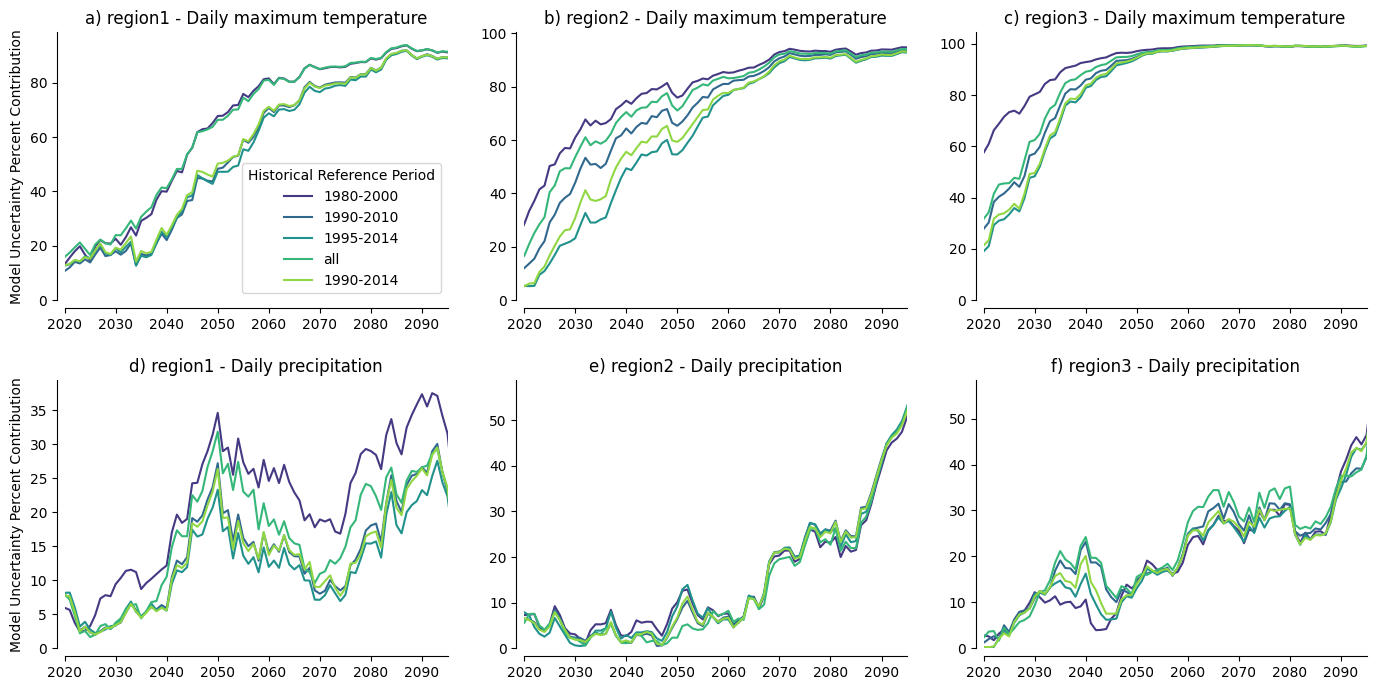

In [102]:
colors = sns.color_palette("viridis", len(test_histslice.concat_dim))
var_dict = {'tasmax': 'Daily maximum temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_histslice['variable'].values):
    for ir, r in enumerate(test_histslice.region.values):
        ax = axs[iv, ir]
        for im in range(len(test_histslice.concat_dim.values)):
            ax.plot(test_histslice.sel(variable=v,region=r).isel(concat_dim=im).time,test_histslice.sel(variable=v,region=r).isel(concat_dim=im).MTratio,c=colors[im])
            # test_return.sel(variable=v, region=r).MTratio.plot(ax=ax,c=colors[im],hue='concat_dim', lw=2,label='Model:Total ratio',add_legend=False)
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
labels = ['1980-2000','1990-2010','1995-2014','all','1990-2014']
axs[0, 0].legend(labels=labels,title='Historical Reference Period')
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/sensitivity_testhistslice.png', dpi=200)

#### Test coarsen

In [28]:
test_coarsen_tas = sensitivity_allregions(parameter='coarsen',
                                          regions=[seattle_tas,sydney_tas,lagos_tas],
                                    x_type = 'quantile_return',
                                    load=False,
                                    args = {'return_period':10,
                                            'coarsen':[1,3,5,7],
                                            'consec_days':1,
                                            'rolling_average':10,
                                            'hist_slice':slice('1995','2014')
                                            
                                           })


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


44.37940216064453



100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


44.371246337890625



100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


44.3768310546875



100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


44.37425994873047



100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


44.36980438232422



100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


44.374244689941406



100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


44.376853942871094



100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


44.374664306640625



100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


44.37293243408203



100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


44.373695373535156



100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


44.377281188964844



100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


44.37471389770508



100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


44.381004333496094



100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


44.37965774536133



100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


44.376529693603516



100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


44.35469436645508



100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


44.363441467285156



100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


44.36642074584961



100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


44.35775375366211



100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


44.373165130615234



100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


44.3744010925293



100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


44.38138961791992



100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


44.37834548950195



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


44.37847900390625



100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


44.37153625488281



100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


44.37425994873047



100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


44.372528076171875



100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


44.37964630126953



100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


44.370933532714844



100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


44.37664794921875



100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


44.36753845214844



100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


44.36892318725586



100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


44.36636734008789



100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


44.36142349243164



100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


44.369625091552734



100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


44.37864303588867



100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


44.37285232543945



100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


44.37919235229492



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


44.38267135620117



100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


44.3834342956543



100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


44.37973403930664



100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


44.37763595581055



100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


44.378719329833984



100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


44.3824577331543



100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


44.37668991088867



100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


44.37871170043945



100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


44.3760871887207



100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


44.37813186645508



100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


44.37691116333008



100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


44.37956619262695



100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


44.378849029541016



100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


44.39451217651367



100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


44.408973693847656



100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


44.48455047607422



100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


44.38279724121094



100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


44.35734176635742



100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


44.3615608215332



100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


44.36223220825195



100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


44.357845306396484



100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

44.37466812133789


In [29]:
test_coarsen_pr = sensitivity_allregions(parameter='coarsen',
                                          regions=[seattle_pr,sydney_pr,lagos_pr],
                                    x_type = 'quantile_return',
                                    load=False,
                                    args = {'return_period':10,
                                            'coarsen':[1,3,5,7],
                                            'consec_days':1,
                                            'rolling_average':10,
                                            'hist_slice':slice('1995','2014')
                                            
                                           })


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


44.38075637817383



100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


44.3745231628418



100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


44.3742561340332



100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


44.37691116333008



100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


44.3807258605957



100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


44.37074661254883



100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


44.37407302856445



100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


44.37594223022461



100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


44.3724250793457



100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


44.37717819213867



100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


44.37815475463867



100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


44.37459182739258



100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


44.37332534790039



100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


44.37108612060547



100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


44.375633239746094



100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


44.377052307128906



100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


44.36976623535156



100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


44.37785339355469



100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


44.37649154663086



100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


44.35991287231445



100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


44.366676330566406



100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


44.36668014526367



100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


44.35891342163086



100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


44.37493133544922



100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


44.364898681640625



100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


44.372745513916016



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


44.37751388549805



100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


44.37233352661133



100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


44.37578201293945



100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


44.36396408081055



100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


44.379886627197266



100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


44.3844108581543



100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


44.385799407958984



100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


44.37543869018555



100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


44.38265609741211



100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


44.371665954589844



100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


44.37767791748047



100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


44.38175964355469



100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


44.38475036621094



100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


44.38292694091797



100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


44.38446807861328



100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


44.37934112548828



100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


44.377723693847656



100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


44.37933349609375



100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


44.37035369873047



100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


44.37262725830078



100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


44.38251876831055



100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


44.379764556884766



100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


44.38298416137695



100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


44.33805465698242



100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


44.383094787597656



100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


44.37683868408203



100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


44.38139343261719



100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


44.377593994140625



100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


44.38359069824219



100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


44.375892639160156



100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


44.38170623779297



100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


44.380332946777344



100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


44.374534606933594



100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

44.375755310058594


In [30]:
variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')
    
test_coarsen = xr.concat([test_coarsen_tas,test_coarsen_pr], dim=variable_dim)

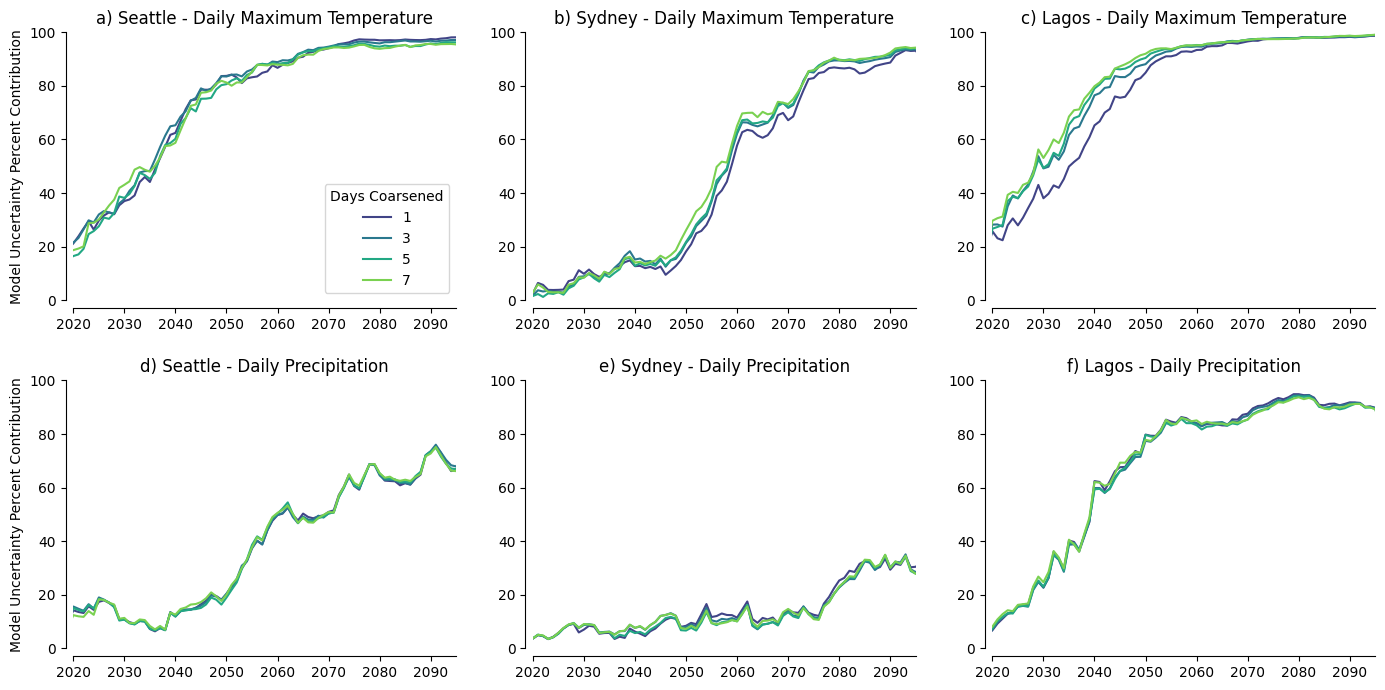

In [31]:
colors = sns.color_palette("viridis", len(test_coarsen.concat_dim))
var_dict = {'tasmax': 'Daily Maximum Temperature', 'pr': 'Daily Precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_coarsen['variable'].values):
    for ir, r in enumerate(test_coarsen.region.values):
        ax = axs[iv, ir]
        for im,m in enumerate(test_coarsen.concat_dim.values):
            ax.plot(test_coarsen.sel(variable=v,region=r,concat_dim=m).time,test_coarsen.sel(variable=v,region=r,concat_dim=m).MTratio,c=colors[im])
            # test_return.sel(variable=v, region=r).MTratio.plot(ax=ax,c=colors[im],hue='concat_dim', lw=2,label='Model:Total ratio',add_legend=False)
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
labels=['1','3','5','7']
axs[0, 0].legend(labels=labels,title='Days Coarsened')
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')
    
for ax in axs[0,:]:
    ax.set_ylim(bottom=0,top=100)
for ax in axs[1,:]:
    ax.set_ylim(bottom=0,top=100)
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/sensitivity_testcoarsen.png', dpi=200)

#### Test consecutive days

In [32]:
test_consec_tas = sensitivity_allregions(parameter='consec_days',
                                         regions=[seattle_tas,sydney_tas,lagos_tas],
                                     x_type='quantile_return',
                                     load=False,
                       args= {'return_period':10,
                              'coarsen':7,
                              'consec_days':[1,3,5,7],
                              'rolling_average':10,
                              'hist_slice':slice('1995','2014')
                             }
                      )


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


44.38471221923828



100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


44.37691116333008



100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


44.38444900512695



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


44.38408279418945



100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

44.38175582885742




100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


44.355709075927734



100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


44.358612060546875



100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


44.36534118652344



100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


44.36484909057617



100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

44.36223220825195




100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


44.37096405029297



100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


44.379817962646484



100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


44.36985397338867



100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


44.38045883178711



100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

44.37211990356445




100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


44.386741638183594



100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


44.3805046081543



100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


44.37912368774414



100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


44.38620376586914



100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


44.38608169555664



100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


44.382144927978516



100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


44.38351058959961



100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


44.38386917114258



100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


44.38594436645508



100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

44.384586334228516




100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


44.38693618774414



100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


44.384212493896484



100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


44.3842887878418



100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


44.389610290527344



100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

44.382652282714844




100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


44.38355255126953



100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


44.391075134277344



100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


44.3843994140625



100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


44.379512786865234



100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

44.38020706176758




100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


44.38333511352539



100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


44.38835525512695



100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


44.3802375793457



100%|██████████| 1/1 [00:06<00:00,  6.36s/it]


44.382049560546875



100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


44.382957458496094



100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


44.38121795654297



100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


44.389312744140625



100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


44.390289306640625



100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


44.38410186767578



100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

44.386268615722656




100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


44.38055419921875



100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


44.38491439819336



100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


44.39443588256836



100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


44.39033508300781



100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

44.38591003417969




100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


44.383201599121094



100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


44.39045715332031



100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


44.394012451171875



100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


44.38720703125



100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

44.386070251464844




100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


44.39402770996094



100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


44.38865661621094



100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


44.392059326171875



100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


44.385108947753906



100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

44.38690948486328


In [33]:
test_consec_pr = sensitivity_allregions(parameter='consec_days',
                                         regions=[seattle_pr,sydney_pr,lagos_pr],
                                     x_type='quantile_return',
                                     load=False,
                       args= {'return_period':10,
                              'coarsen':7,
                              'consec_days':[1,3,5,7],
                              'rolling_average':10,
                              'hist_slice':slice('1995','2014')
                             }
                      )


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


44.388938903808594



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


44.38764953613281



100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


44.38728332519531



100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


44.38941192626953



100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

44.388084411621094




100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


44.38475799560547



100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


44.38020324707031



100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


44.38133239746094



100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


44.38372802734375



100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

44.382301330566406




100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


44.381492614746094



100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


44.37946319580078



100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


44.38124084472656



100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


44.38523864746094



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

44.38656997680664




100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


44.38471603393555



100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


44.526554107666016



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


44.392494201660156



100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


44.3808708190918



100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


44.38444137573242



100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


44.38655471801758



100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


44.38527297973633



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


44.37887954711914



100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


44.37873458862305



100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

44.383968353271484




100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


44.3846321105957



100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


44.38727951049805



100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


44.39030075073242



100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


44.387939453125



100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

44.39539337158203




100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


44.3818473815918



100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


44.38590621948242



100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


44.388545989990234



100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


44.37042999267578



100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

44.38024139404297




100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


44.37572479248047



100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


44.380393981933594



100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


44.37675476074219



100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


44.38262176513672



100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


44.381954193115234



100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


44.3853874206543



100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


44.378971099853516



100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


44.37947463989258



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


44.38593673706055



100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

44.39028549194336




100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


44.389400482177734



100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


44.39104080200195



100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


44.39013671875



100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


44.39714050292969



100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

44.39470291137695




100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


44.39666748046875



100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


44.391212463378906



100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


44.39885711669922



100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


44.374664306640625



100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

44.343406677246094




100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


44.385562896728516



100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


44.37882614135742



100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


44.3863639831543



100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


44.384159088134766



100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

44.38285446166992


In [34]:
variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')
    
test_consec = xr.concat([test_consec_tas,test_consec_pr], dim=variable_dim)

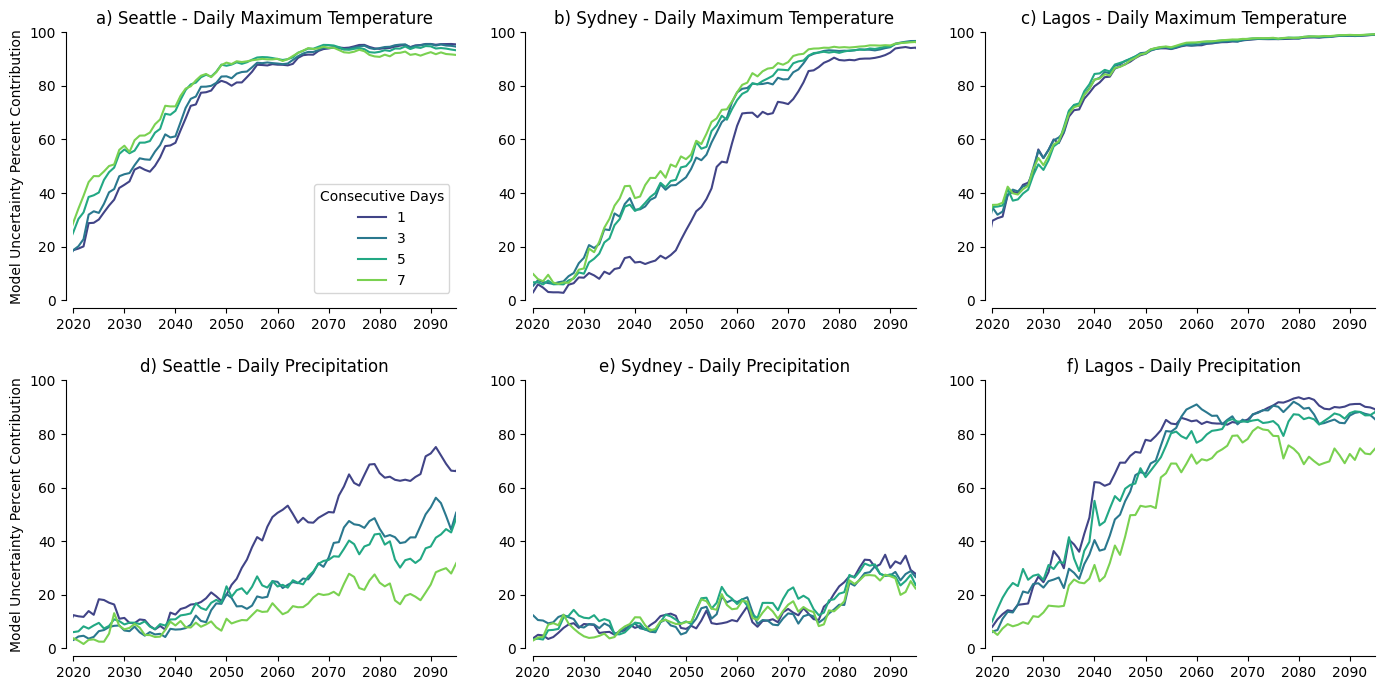

In [36]:
colors = sns.color_palette("viridis", len(test_consec.concat_dim))
var_dict = {'tasmax': 'Daily Maximum Temperature', 'pr': 'Daily Precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_consec['variable'].values):
    for ir, r in enumerate(test_consec.region.values):
        ax = axs[iv, ir]
        for im,m in enumerate(test_consec.concat_dim.values):
            ax.plot(test_consec.sel(variable=v,region=r,concat_dim=m).time,test_consec.sel(variable=v,region=r,concat_dim=m).MTratio,c=colors[im])
            # test_return.sel(variable=v, region=r).MTratio.plot(ax=ax,c=colors[im],hue='concat_dim', lw=2,label='Model:Total ratio',add_legend=False)
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
labels=['1','3','5','7']
axs[0, 0].legend(labels=labels,title='Consecutive Days')
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')

for ax in axs[0,:]:
    ax.set_ylim(bottom=0,top=100)
for ax in axs[1,:]:
    ax.set_ylim(bottom=0,top=100)
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/sensitivity_testconsec.png', dpi=200)

#### test rolling average

In [37]:
test_rolling_tas = sensitivity_allregions(parameter='rolling_average',
                                          regions=[seattle_tas,sydney_tas,lagos_tas],
                                       x_type='quantile_return',
                                     load=False,
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'consec_days':1,
                                                'rolling_average':[1,5,10,15,20],
                                                'hist_slice':slice('1995','2014')
                                               }
                                     )


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


44.390628814697266



100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


44.39262008666992



100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


44.391300201416016



100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


44.38645553588867



100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


44.377952575683594



100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


44.39151382446289



100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


44.34548568725586



100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


44.37147903442383



100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


44.38141632080078



100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


44.38146209716797



100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


44.3857421875



100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


44.387752532958984



100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


44.38588333129883



100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


44.38515853881836



100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


44.38789749145508



100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


44.3896598815918



100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


44.3826789855957



100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


44.389705657958984



100%|██████████| 1/1 [00:05<00:00,  5.92s/it]


44.3902473449707



100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


44.38616180419922



100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


44.35812759399414



100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


44.36404800415039



100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


44.37324142456055



100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


44.36879348754883



100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


44.389625549316406



100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


44.385719299316406



100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


44.37452697753906



100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


44.37407684326172



100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


44.37672424316406



100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


44.407318115234375



100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


44.39319610595703



100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


44.570045471191406



100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


44.37572479248047



100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


44.37908172607422



100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


44.38587951660156



100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


44.383731842041016



100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


44.38528060913086



100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


44.386417388916016



100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


44.38796615600586



100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


44.39116287231445



100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


44.373592376708984



100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


44.36146545410156



100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


44.37589645385742



100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


44.38202667236328



100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


44.374534606933594



100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


44.369544982910156



100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


44.36214828491211



100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


44.36561965942383



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


44.38264846801758



100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


44.37971496582031



100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


44.38191223144531



100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


44.38978576660156



100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


44.384071350097656



100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


44.37834167480469



100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


44.38511657714844



100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


44.38420486450195



100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


44.358856201171875



100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


44.370941162109375



100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


44.38161087036133



100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


44.379966735839844



100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


44.38922882080078



100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


44.374332427978516



100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


44.376895904541016



100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


44.37141036987305



100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


44.373077392578125



100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


44.364253997802734



100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


44.38142395019531



100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


44.38407897949219



100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


44.377052307128906



100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


44.383522033691406



100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


44.38285827636719



100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


44.378997802734375



100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


44.380165100097656



100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


44.381874084472656



100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

44.355587005615234


In [38]:
test_rolling_pr = sensitivity_allregions(parameter='rolling_average',
                                          regions=[seattle_pr,sydney_pr,lagos_pr],
                                       x_type='quantile_return',
                                     load=False,
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'consec_days':1,
                                                'rolling_average':[1,5,10,15,20],
                                                'hist_slice':slice('1995','2014')
                                               }
                                     )


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


44.393821716308594



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


44.3879508972168



100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


44.38820266723633



100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


44.39158248901367



100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


44.3947868347168



100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


44.391910552978516



100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


44.39534378051758



100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


44.388057708740234



100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


44.3978157043457



100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


44.39162063598633



100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


44.394657135009766



100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


44.392555236816406



100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


44.38549041748047



100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


44.390342712402344



100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


44.38966369628906



100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


44.36762237548828



100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


44.38858413696289



100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


44.39080810546875



100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


44.376304626464844



100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


44.3848876953125



100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


44.388832092285156



100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


44.39060974121094



100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


44.39125061035156



100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


44.39411926269531



100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


44.388099670410156



100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


44.384674072265625



100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


44.38728332519531



100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


44.39031982421875



100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


44.393585205078125



100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


44.390411376953125



100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


44.38861083984375



100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


44.39944076538086



100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


44.396121978759766



100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


44.4012565612793



100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


44.39868927001953



100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


44.39792251586914



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


44.397682189941406



100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


44.40028381347656



100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


44.390235900878906



100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


44.39105224609375



100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


44.3813362121582



100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


44.395572662353516



100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


44.39751052856445



100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


44.39315414428711



100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


44.39326858520508



100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


44.39415740966797



100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


44.38727569580078



100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


44.390296936035156



100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


44.397315979003906



100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


44.390052795410156



100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


44.391475677490234



100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


44.39273452758789



100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


44.38967514038086



100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


44.39638137817383



100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


44.39673614501953



100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


44.398948669433594



100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


44.39479064941406



100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


44.39386749267578



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


44.39308166503906



100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


44.39216613769531



100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


44.401145935058594



100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


44.37504577636719



100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


44.376121520996094



100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


44.38129806518555



100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


44.37362289428711



100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


44.37881851196289



100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


44.392723083496094



100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


44.393096923828125



100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


44.392051696777344



100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


44.39823913574219



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


44.391761779785156



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


44.388648986816406



100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


44.389556884765625



100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


44.387794494628906



100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

44.38118362426758


In [39]:
variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')
    
test_rolling = xr.concat([test_rolling_tas,test_rolling_pr], dim=variable_dim)

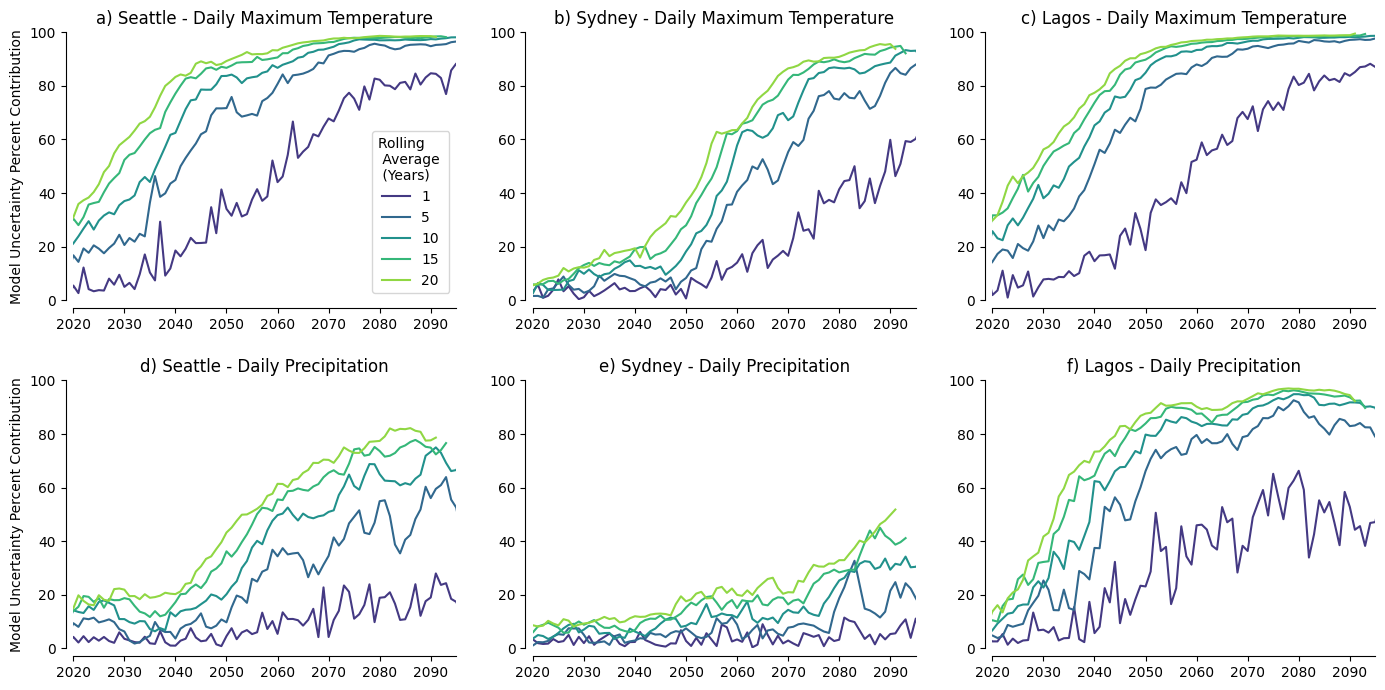

In [42]:
colors = sns.color_palette("viridis", len(test_rolling.concat_dim))
var_dict = {'tasmax': 'Daily Maximum Temperature', 'pr': 'Daily Precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_rolling['variable'].values):
    for ir, r in enumerate(test_rolling.region.values):
        ax = axs[iv, ir]
        for im,m in enumerate(test_rolling.concat_dim.values):
            ax.plot(test_rolling.sel(variable=v,region=r,concat_dim=m).time,test_rolling.sel(variable=v,region=r,concat_dim=m).MTratio,c=colors[im])
            # test_return.sel(variable=v, region=r).MTratio.plot(ax=ax,c=colors[im],hue='concat_dim', lw=2,label='Model:Total ratio',add_legend=False)
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
labels=['1','5','10','15','20']
axs[0, 0].legend(labels=labels,title='Rolling \n Average \n (Years)')
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')
    
for ax in axs[0,:]:
    ax.set_ylim(bottom=0,top=100)
for ax in axs[1,:]:
    ax.set_ylim(bottom=0,top=100)
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/sensitivity_testrolling.png', dpi=200)

### Tas vs Tasmax

In [43]:
# load global data 
tasmax_mmle = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [44]:
tasmax_mmle.compute_x(x_type='quantile_return', load=True, name='tasmax_default_quantile_return_10yr')

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/CanESM5.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/EC-Earth3.zarr


In [45]:
tasmax_mmle.x.load()
tasmax_mmle.compute_LE()
tasmax_mmle.compute_FIT()
internal_tasmax = tasmax_mmle.results
tasmax = tasmax_mmle.x

In [46]:
# load global data 
tas_mmle = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'tas', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [47]:
tas_mmle.compute_x(x_type='quantile_return', load=True, name='tas_default_quantile_return_10yr')

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tas_default_quantile_return_10yr/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tas_default_quantile_return_10yr/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tas_default_quantile_return_10yr/CanESM5.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tas_default_quantile_return_10yr/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tas_default_quantile_return_10yr/EC-Earth3.zarr


In [48]:
tas_mmle.x.load()
tas_mmle.compute_LE()
tas_mmle.compute_FIT()
internal_tas = tas_mmle.results
tas = tas_mmle.x

In [49]:
# regions = ['region1', 'region2', 'region3']
# lats = [51, 3.9, -25.2]
# lons = [10.5, 306.9, 133.7]
# region_dim = xr.DataArray(regions, coords={'region': regions})

regions = ['Seattle', 'Sydney', 'Lagos']
lats = [47.6, -33.8, 6.5]
lons = [237.7, 151.2, 3.4]
region_dim = xr.DataArray(regions, coords={'region': regions})

In [50]:
x = xr.merge([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
).drop('q_values') for ds in [tas, tasmax]])

In [51]:
x = x.to_array()

In [52]:
variable_dim = xr.DataArray(['tas', 'tasmax'], coords={'variable': ['tas', 'tasmax']}, name='variable')

In [53]:
internal = xr.concat([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
) for ds in [internal_tas, internal_tasmax]], dim=variable_dim)

In [54]:
internal['MTratio'] = (internal.M_LE/(internal.M_LE+internal.Ibar_LE))*100

In [55]:
internal

<xarray.Dataset>
Dimensions:    (variable: 2, time: 181, region: 3, model: 5)
Coordinates:
  * variable   (variable) <U6 'tas' 'tasmax'
  * time       (time) datetime64[ns] 1920-01-01 1921-01-01 ... 2100-01-01
    lat        (region) float64 47.5 -35.0 7.5
    lon        (region) float64 237.5 150.0 2.5
  * model      (model) <U13 'MIROC6' 'cesm_lens' ... 'MPI-ESM1-2-LR' 'EC-Earth3'
    q_values   (variable, model, region) float64 298.6 307.6 ... 315.9 313.6
    quantile   (model) float64 0.9997 0.9997 0.9997 0.9997 0.9997
    member_id  int64 1
  * region     (region) <U7 'Seattle' 'Sydney' 'Lagos'
Data variables:
    M_LE       (variable, time, region) float64 nan nan nan nan ... nan nan nan
    I_LE       (variable, model, time, region) float64 nan nan nan ... nan nan
    Ibar_LE    (variable, time, region) float64 nan nan nan nan ... nan nan nan
    T_LE       (variable, time, region) float64 nan nan nan nan ... nan nan nan
    FIT        (variable, time, model, region) float64 18.83 11.61 ... 586.3
    M_FIT      (variable, time, region) float64 5.875e+03 ... 9.369e+04
    I_FIT      (variable, model, region) float64 70.86 18.61 ... 8.435 228.2
    Ibar_FIT   (variable, region) float64 194.8 25.79 364.3 109.6 14.75 118.4
    T_FIT      (variable, time, region) float64 nan nan nan nan ... nan nan nan
    MTratio    (variable, time, region) float64 nan nan nan nan ... nan nan nan

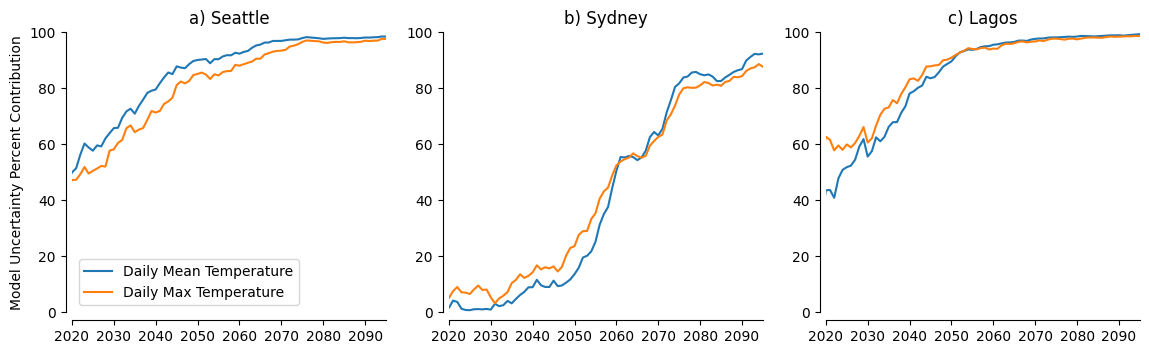

In [57]:
colors = sns.color_palette("viridis", len(test_rolling.concat_dim))
var_dict = {'tasmax': 'Daily maximum temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=1,ncols=3, constrained_layout=True,figsize=(12,4))

axes = [axs[0],axs[1],axs[2]]
regions = ['Seattle','Sydney','Lagos']
count=0
for ax,r in zip(axes,regions):
    ax.plot(internal.sel(variable='tas',region=r).time,internal.sel(variable='tas',region=r).MTratio,label='Daily Mean Temperature')
    ax.plot(internal.sel(variable='tasmax',region=r).time,internal.sel(variable='tasmax',region=r).MTratio,label='Daily Max Temperature')
    
    ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
    ax.set_ylim(bottom=0,top=100)
    ax.set_title(f'{string.ascii_lowercase[count]}) {r}')
    ax.set_xlabel('')
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines["bottom"].set_position(("axes", -0.03)) 
    ax.spines["left"].set_position(("axes", -0.02))
    count += 1
axs[0].legend()
axs[0].set_ylabel('Model Uncertainty Percent Contribution')

plt.subplots_adjust(left=0.1, right=0.99, bottom=0.2, top=0.9, wspace=0.20, hspace=0.70)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/sensitivity_tastasmax.png', dpi=200)

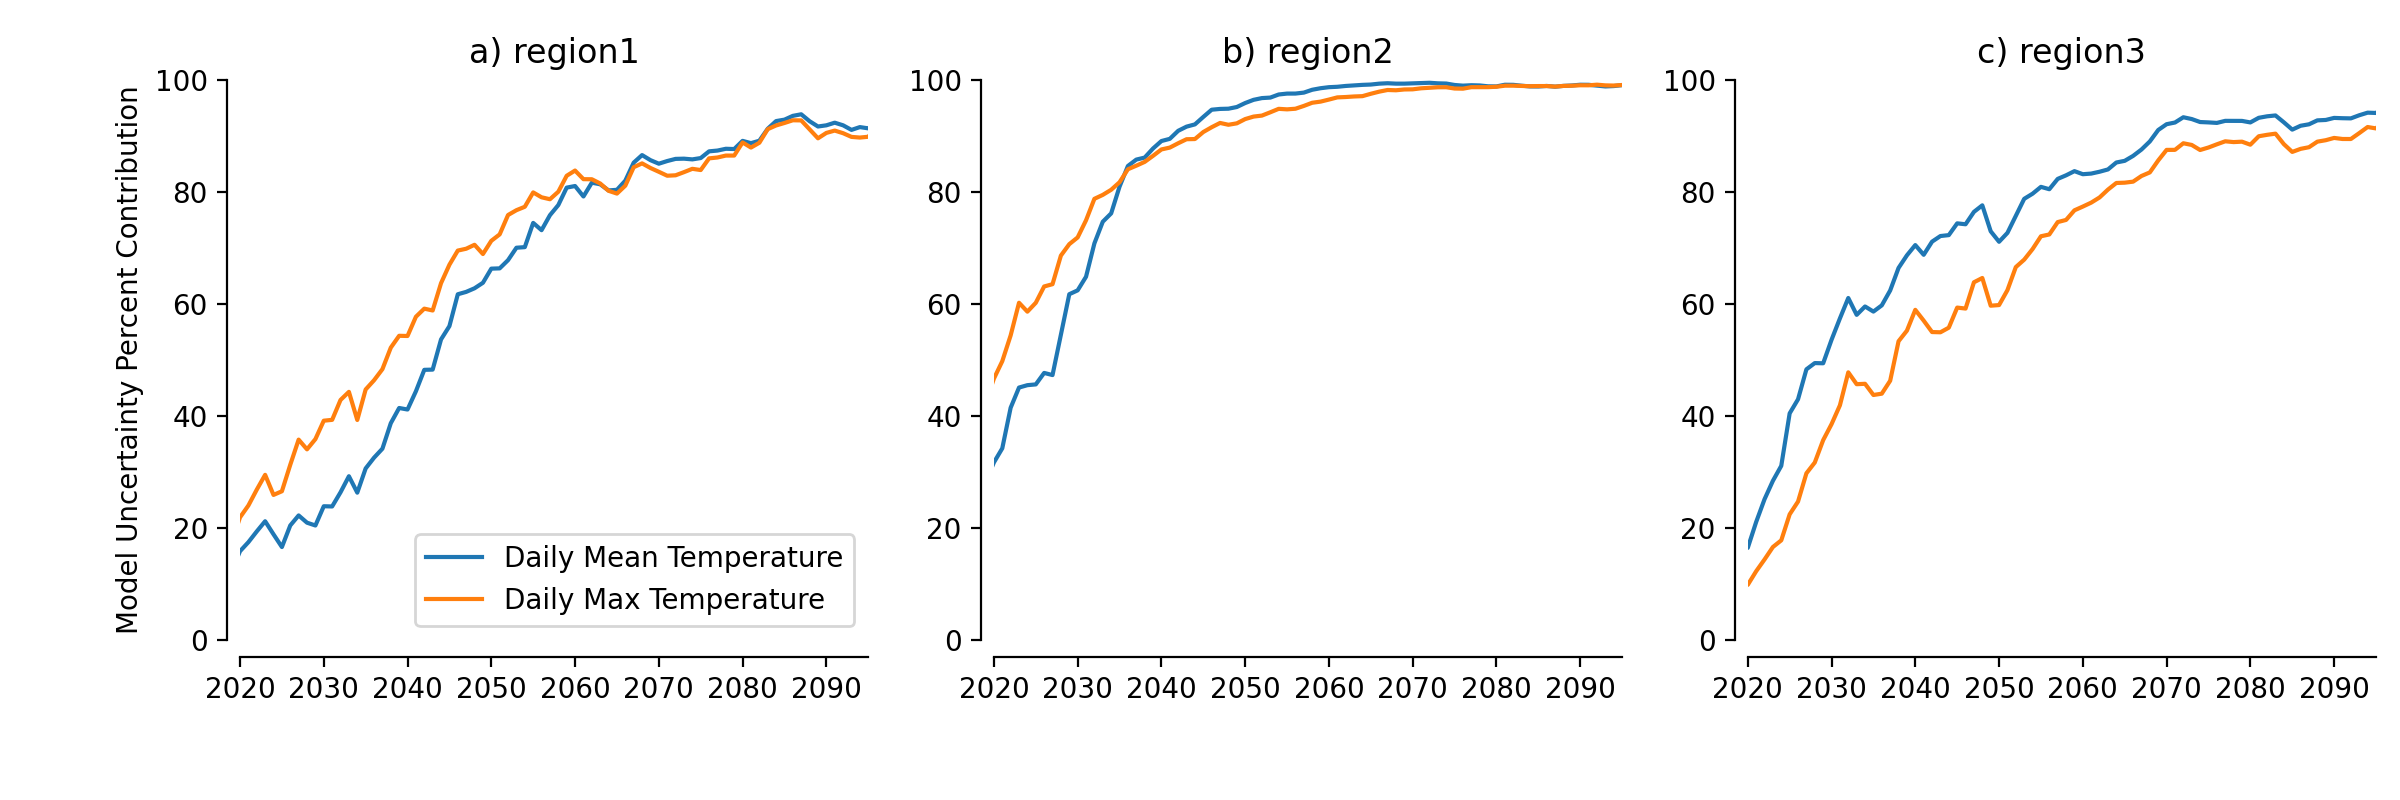

In [220]:
from IPython.display import Image
Image(filename='./plots/sensitivity_tastasmax.png')   # Don't believe what Jupyter shows you!

## Default vs TXx returns vx TXx

### Default

In [221]:
# load global data 
tasmax_default = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

tasmax_default.compute_x(x_type='quantile_return', load=True, name='tasmax_default_quantile_return_10yr')

tasmax_default.x.load()
tasmax_default.compute_LE()
tasmax_default.compute_FIT()
internal_tasmax_default = tasmax_default.results
tasmax_default = tasmax_default.x

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/CanESM5.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/EC-Earth3.zarr


In [222]:
# load global data 
pr_default = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'pr', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

pr_default.compute_x(x_type='quantile_return', load=True, name='pr_default_quantile_return_10yr')

pr_default.x.load()
pr_default.compute_LE()
pr_default.compute_FIT()
internal_pr_default = pr_default.results
pr_default = pr_default.x

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/CanESM5.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/EC-Earth3.zarr


In [223]:
regions = ['region1', 'region2', 'region3']
lats = [51, 3.9, -25.2]
lons = [10.5, 306.9, 133.7]
region_dim = xr.DataArray(regions, coords={'region': regions})

x_default = xr.merge([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
).drop('q_values') for ds in [tasmax_default, pr_default]])

x_default = x_default.to_array()

variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')

internal_default = xr.concat([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
) for ds in [internal_tasmax_default, internal_pr_default]], dim=variable_dim)

internal_default['MTratio'] = (internal_default.M_LE/(internal_default.M_LE+internal_default.Ibar_LE))*100

### TXx Return

In [224]:
# load global data 
tasmax_TXx_return = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

tasmax_TXx_return.compute_x(x_type='TXx_quantile', load=True, name='tasmax_TXx_quantile_return_10yr')

tasmax_TXx_return.x.load()
tasmax_TXx_return.compute_LE()
tasmax_TXx_return.compute_FIT()
internal_tasmax_TXx_return = tasmax_TXx_return.results
tasmax_TXx_return = tasmax_TXx_return.x

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_TXx_quantile_return_10yr/MIROC6.zarr


KeyError: '.zmetadata'

In [ ]:
# load global data 
pr_TXx_return = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'pr', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

pr_TXx_return.compute_x(x_type='TXx_quantile', load=True, name='pr_TXx_quantile_return_10yr')

pr_TXx_return.x.load()
pr_TXx_return.compute_LE()
pr_TXx_return.compute_FIT()
internal_pr_TXx_return = pr_TXx_return.results
pr_TXx_return = pr_TXx_return.x

In [ ]:
regions = ['region1', 'region2', 'region3']
lats = [51, 3.9, -25.2]
lons = [10.5, 306.9, 133.7]
region_dim = xr.DataArray(regions, coords={'region': regions})

x_TXx_return = xr.merge([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
).drop('q_values') for ds in [tasmax_TXx_return, pr_TXx_return]])

x_TXx_return = x_TXx_return.to_array()

variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')

internal_TXx_return = xr.concat([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
) for ds in [internal_tasmax_TXx_return, internal_pr_TXx_return]], dim=variable_dim)

internal_TXx_return['MTratio'] = (internal_TXx_return.M_LE/(internal_TXx_return.M_LE+internal_TXx_return.Ibar_LE))*100

### TXx

In [ ]:
# load global data 
tasmax_TXx = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

tasmax_TXx.compute_x(x_type='max', load=True, name='tasmax_TXx_quantile_return_10yr')

tasmax_TXx.x.load()
tasmax_TXx.compute_LE()
tasmax_TXx.compute_FIT()
internal_tasmax_TXx = tasmax_TXx.results
tasmax_TXx = tasmax_TXx.x

In [ ]:
# load global data 
pr_TXx = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'pr', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

pr_TXx.compute_x(x_type='max', load=True, name='pr_TXx_quantile_return_10yr')

pr_TXx.x.load()
pr_TXx.compute_LE()
pr_TXx.compute_FIT()
internal_pr_TXx = pr_TXx.results
pr_TXx = pr_TXx.x

In [ ]:
regions = ['region1', 'region2', 'region3']
lats = [51, 3.9, -25.2]
lons = [10.5, 306.9, 133.7]
region_dim = xr.DataArray(regions, coords={'region': regions})

x_TXx = xr.merge([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
).drop('q_values') for ds in [tasmax_TXx, pr_TXx]])

x_TXx = x_TXx.to_array()

variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')

internal_TXx = xr.concat([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
) for ds in [internal_tasmax_TXx, internal_pr_TXx]], dim=variable_dim)

internal_TXx['MTratio'] = (internal_TXx.M_LE/(internal_TXx.M_LE+internal_TXx.Ibar_LE))*100

In [ ]:
colors = ['k','b','g','r','orange']
var_dict = {'tasmax': 'Daily maximum temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(internal_default['variable'].values):
    for ir, r in enumerate(internal_default.region.values):
        ax = axs[iv, ir]

        internal_default.sel(variable=v, region=r).MTratio.plot(ax=ax, lw=2,label='Extreme Default')
        internal_TXx_return.sel(variable=v, region=r).MTratio.plot(ax=ax, lw=2,label='Extreme TXx Return')
        internal_TXx.sel(variable=v, region=r).MTratio.plot(ax=ax, lw=2,label='Extreme TXx')
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
axs[0, 0].legend()
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
# fig.savefig('./plots/sensitivity_extreme_defs.png', dpi=200)

### plots

In [70]:
test_return

<xarray.Dataset>
Dimensions:     (time: 106, region: 3, concat_dim: 5, model: 5)
Coordinates:
  * time        (time) datetime64[ns] 1995-01-01 1996-01-01 ... 2100-01-01
    lat         (region) float64 50.0 -25.0 5.0
    lon         (region) float64 10.0 132.5 307.5
  * model       (model) <U13 'MIROC6' 'CanESM5' ... 'EC-Earth3' 'cesm_lens'
    quantile    (model) float64 0.9995 0.9995 0.9995 0.9995 0.9995
    q_values    (region, model) float64 0.0005008 0.0003303 ... 0.0003968
    member_id   int64 1
  * concat_dim  (concat_dim) int64 5 10 20 50 100
  * region      (region) <U7 'region1' 'region2' 'region3'
Data variables:
    M_LE        (region, concat_dim, time) float64 nan nan nan ... nan nan nan
    I_LE        (region, concat_dim, model, time) float64 nan nan ... nan nan
    Ibar_LE     (region, concat_dim, time) float64 nan nan nan ... nan nan nan
    T_LE        (region, concat_dim, time) float64 nan nan nan ... nan nan nan
    FIT         (region, concat_dim, time, model) float64 -3.01 ... -0.8932
    M_FIT       (region, concat_dim, time) float64 6.309 4.758 ... 0.5905 0.7323
    I_FIT       (region, concat_dim, model) float64 2.954 1.592 ... 0.06174
    Ibar_FIT    (region, concat_dim) float64 1.726 0.8384 ... 0.1543 0.1044
    T_FIT       (region, concat_dim, time) float64 nan nan nan ... nan nan nan
    MTratio     (region, concat_dim, time) float64 nan nan nan ... nan nan nan

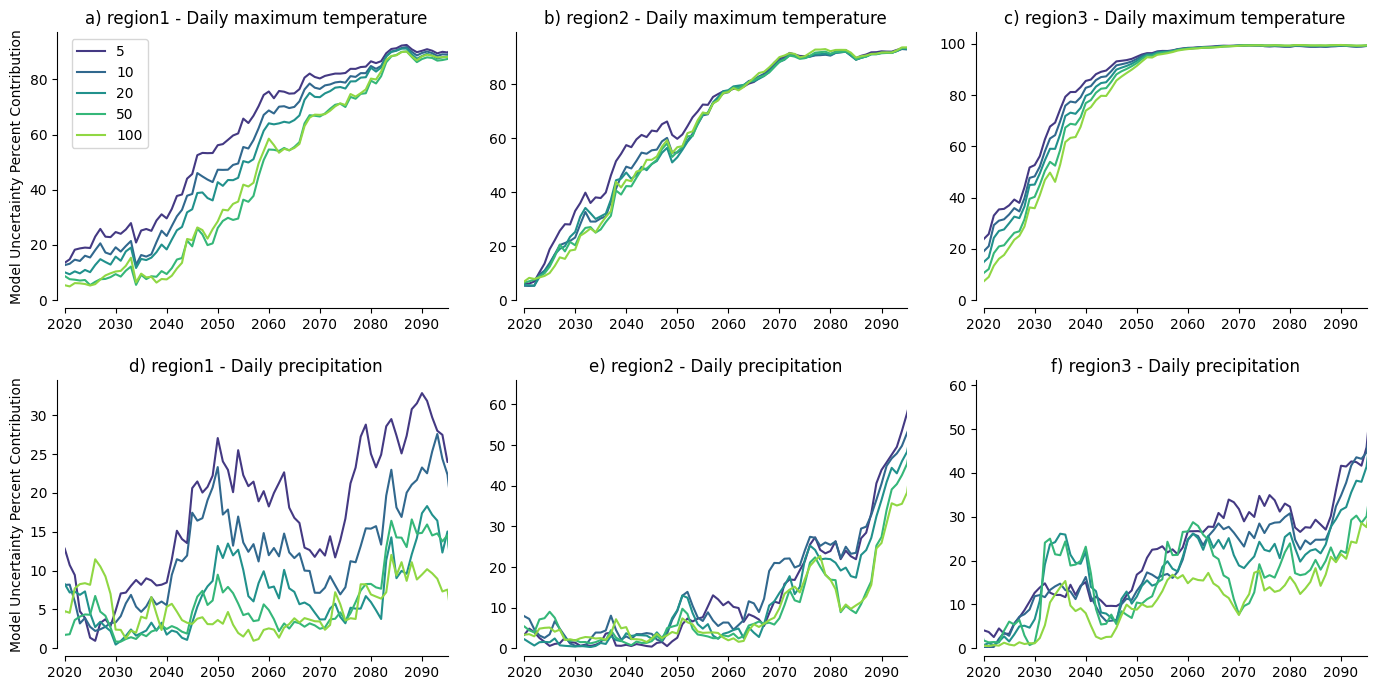

In [91]:
# colors = ['k','b','g','r','orange']
colors = sns.color_palette("viridis", len(test_return.concat_dim))
var_dict = {'tasmax': 'Daily maximum temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_return['variable'].values):
    for ir, r in enumerate(test_return.region.values):
        ax = axs[iv, ir]
        for im,m in enumerate(test_return.concat_dim.values):
        # for im, m in enumerate(internal.model.values):
            ax.plot(test_return.sel(variable=v,region=r,concat_dim=m).time,test_return.sel(variable=v,region=r,concat_dim=m).MTratio,c=colors[im])
            # test_return.sel(variable=v, region=r).MTratio.plot(ax=ax,c=colors[im],hue='concat_dim', lw=2,label='Model:Total ratio',add_legend=False)
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
labels=['5','10','20','50','100']
axs[0, 0].legend(labels=labels)
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
# fig.savefig('./plots/std_uncertainties_noscenario.png', dpi=200)

ValueError: x and y can be no greater than 2D, but have shapes (181,) and (181, 71, 144)

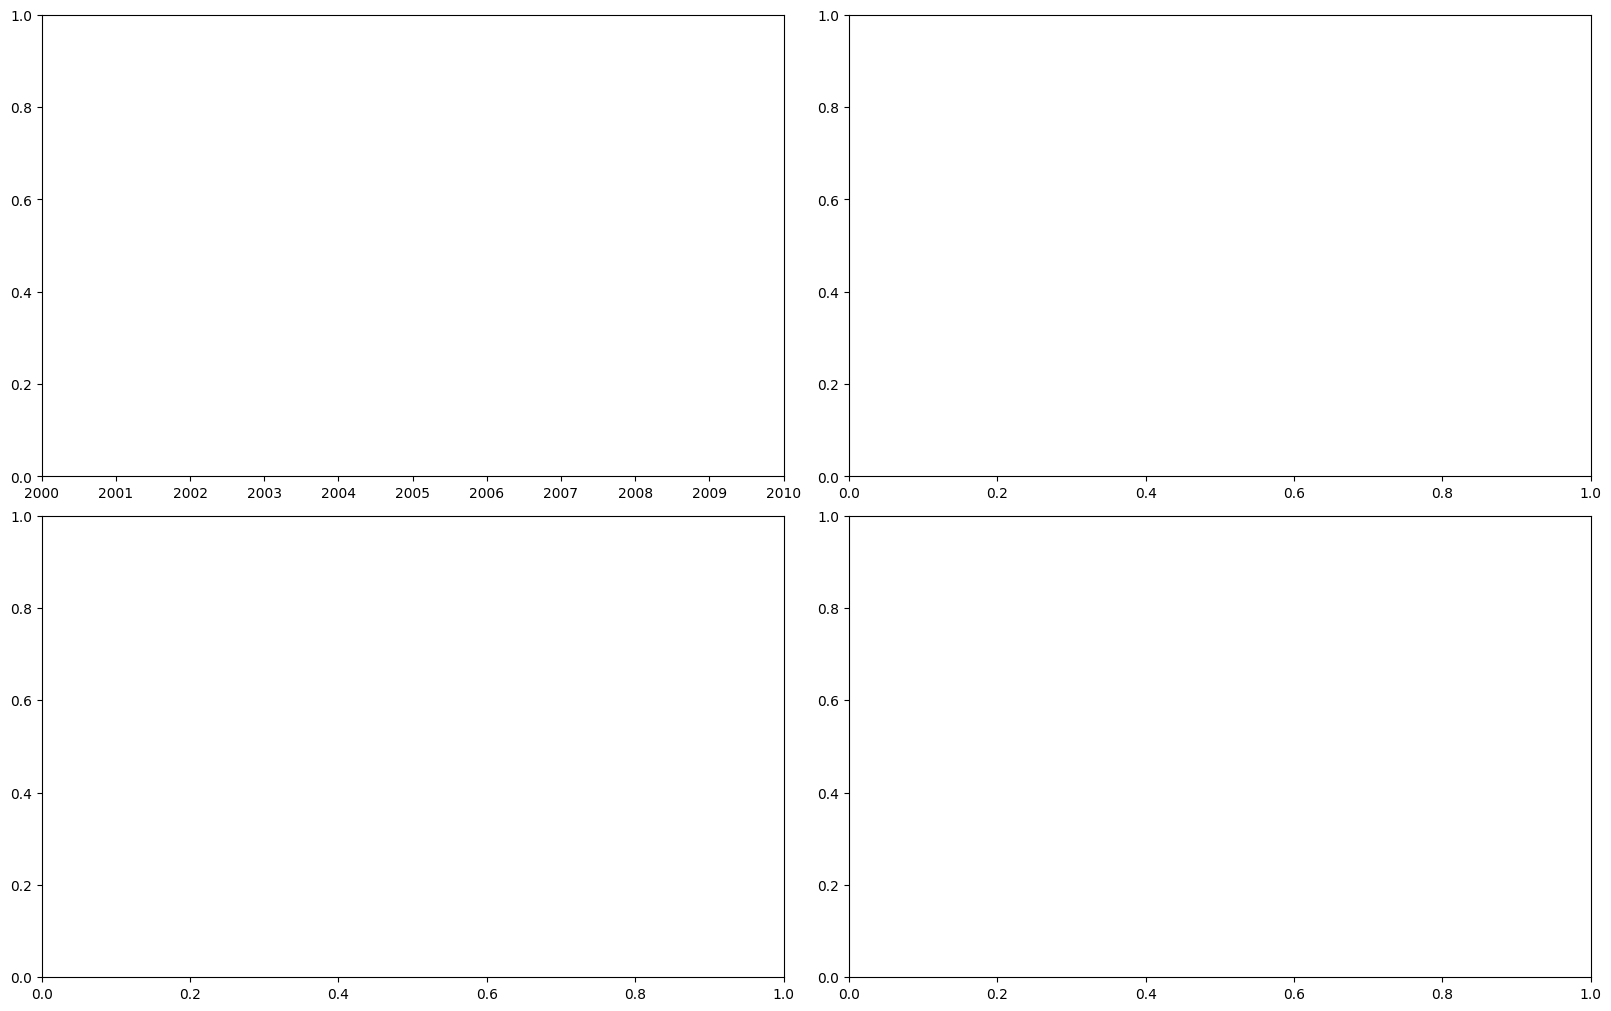

In [40]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("viridis", len(test_return.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_return.concat_dim):
        axe.plot(test_return.sel(region=r,concat_dim=m).time,test_return.sel(region=r,concat_dim=m).MTratio,
                c=colors[i])
        labels=['5','10','20','50','100']
        axe.legend(labels=labels,loc=2,title='Return Period')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,70)

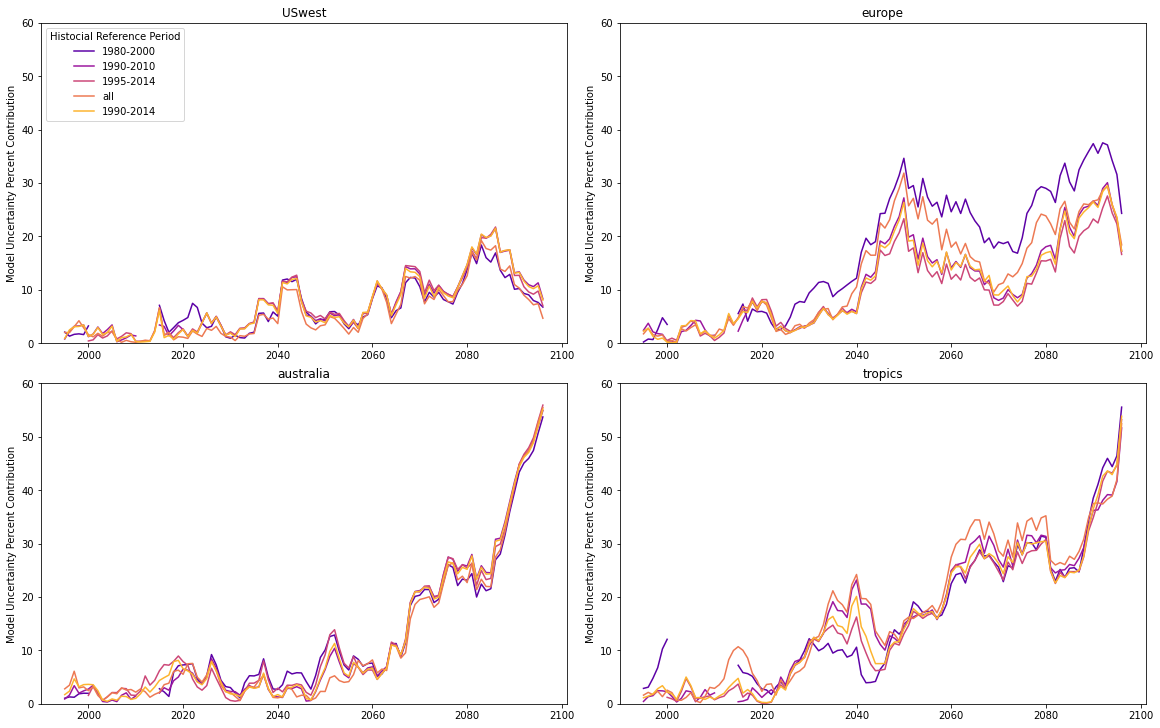

In [44]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("plasma", len(test_histslice.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i in range(len(test_histslice.concat_dim)):
        axe.plot(test_histslice.sel(region=r).isel(concat_dim=i).time,
                 test_histslice.sel(region=r).isel(concat_dim=i).MTratio,
                c=colors[i])
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,60)
labels = ['1980-2000','1990-2010','1995-2014','all','1990-2014']
ax[0,0].legend(labels=labels,loc=2,title='Histocial Reference Period')

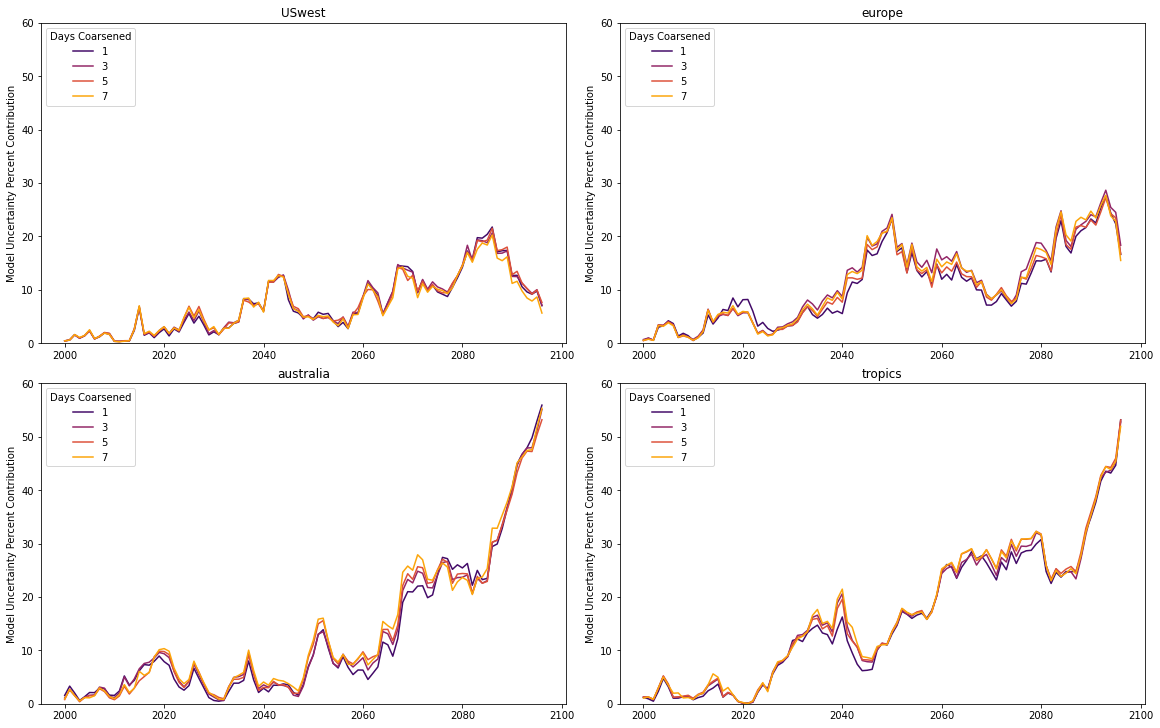

In [46]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("inferno", len(test_coarsen.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_coarsen.concat_dim):
        axe.plot(test_coarsen.sel(region=r,concat_dim=m).time,test_coarsen.sel(region=r,concat_dim=m).MTratio,
                c=colors[i])
        labels=['1','3','5','7']
        axe.legend(labels=labels,loc=2,title='Days Coarsened')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,60)

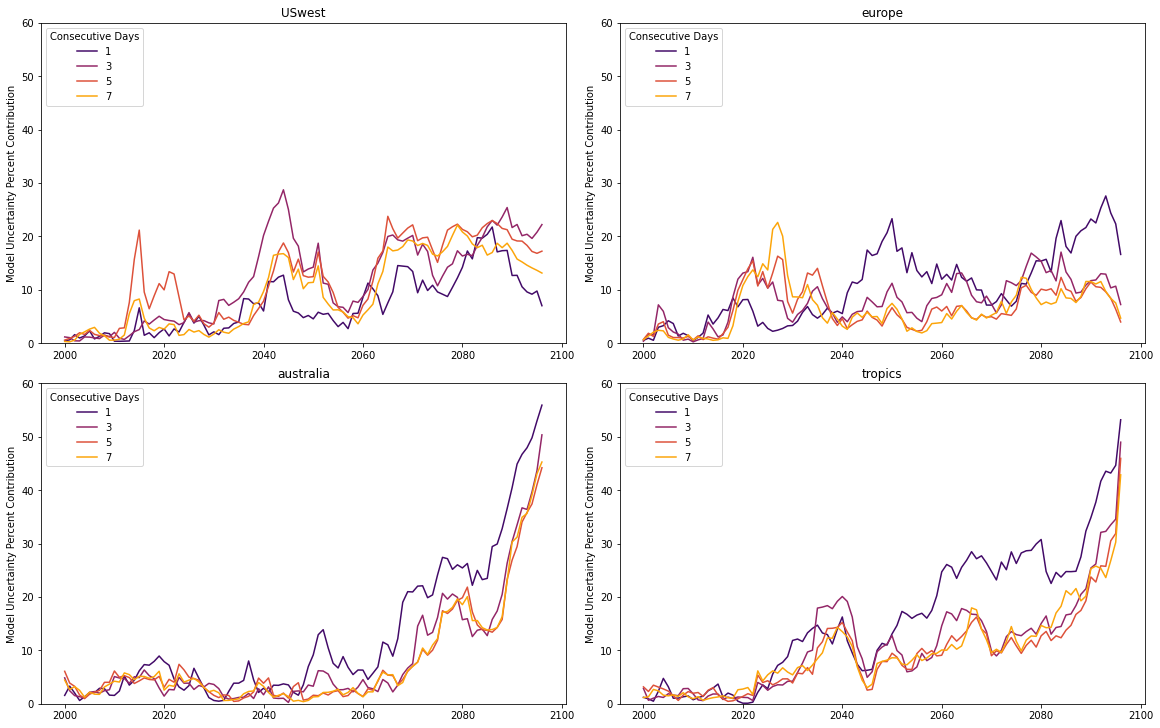

In [49]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("inferno", len(test_conseq.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_conseq.concat_dim):
        axe.plot(test_conseq.sel(region=r,concat_dim=m).time,test_conseq.sel(region=r,concat_dim=m).MTratio,
                c=colors[i])
        labels=['1','3','5','7']
        axe.legend(labels=labels,loc=2,title='Consecutive Days')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,60)

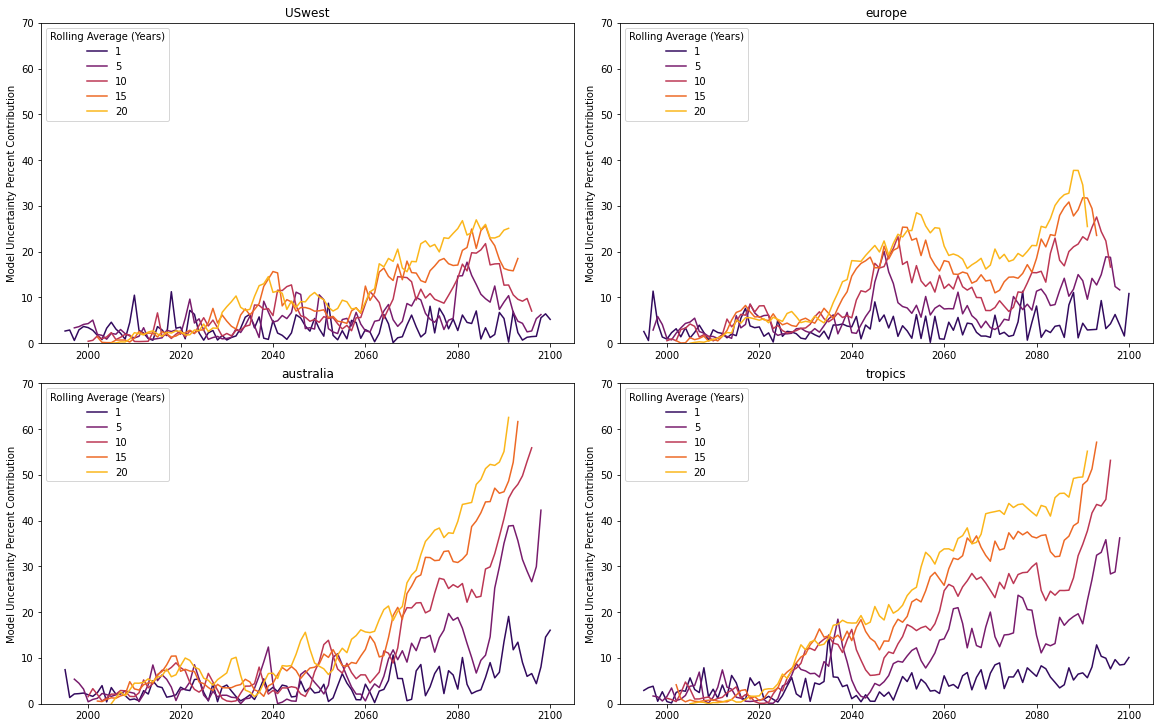

In [53]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("inferno", len(test_rolling.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_rolling.concat_dim):
        axe.plot(test_rolling.sel(region=r,concat_dim=m).time,test_rolling.sel(region=r,concat_dim=m).MTratio,
                c=colors[i])
        labels=['1','5','10','15','20']
        axe.legend(labels=labels,loc=2,title='Rolling Average (Years)')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,70)

## Load Datasets - Local code 

In [90]:
# settings 
#for temp
# variable = 'tas'
# models = ['CanESM5','cesm_lens','MIROC6','MPI-ESM1-2-LR','EC-Earth3'] 

#for precip - still having issues getting EC-Earth data 
variable = 'pr'
models = ['CanESM5','cesm_lens','MIROC6','MPI-ESM1-2-LR'] 

In [91]:
# USeast = MultiModelLargeEnsemble(models=models,
#                                  variable=variable, granularity='day', lat=41.3, 
#                                  lon=-72.5,bucket='climateai_data_repository', 
#                                  path='tmp/internal_variability',
#                                  load=True)

In [92]:
USwest = MultiModelLargeEnsemble(models=models, scenario='ssp585',
                                 variable=variable, granularity='day', lat=37.7, lon=-122.4,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True,single_member=False)

In [93]:
# iceland = MultiModelLargeEnsemble(models=models,
#                                  variable=variable, granularity='day', lat=65, lon=-19,
#                                  bucket='climateai_data_repository', 
#                                  path='tmp/internal_variability',
#                                  load=True)

In [94]:
europe = MultiModelLargeEnsemble(models=models,scenario='ssp585',
                                 variable=variable, granularity='day', lat=51,lon=10.5,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True,single_member=False)

In [95]:
australia = MultiModelLargeEnsemble(models=models, scenario='ssp585',
                                 variable=variable, granularity='day', lat=-25.2,lon=133.7,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True,single_member=False)

In [96]:
tropics = MultiModelLargeEnsemble(models=models,scenario='ssp585',
                                 variable=variable, granularity='day', lat=3.9,lon=-53.1,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True,single_member=False)

### sensitivity testing
using model:internal ratio for testing the various parameters. When ratio > 1, model uncertainty dominates. When ratio < 1, internal variability dominates. 

### Return periods 

In [68]:
test_return = sensitivity_allregions(parameter='return_period',
                                     args = {'return_period':[5,10,20, 50, 100],
                                                'coarsen':1,
                                                'conseq_days':1,
                                                'rolling_average':10,
                                                'hist_slice':slice('1995','2014'),
                                             'postprocess':True
                                               })

In [69]:
test_return

<xarray.Dataset>
Dimensions:            (time: 86, member: 58, model: 5, concat_dim: 5, region: 4)
Coordinates:
  * time               (time) datetime64[ns] 2015-01-01 ... 2100-01-01
  * member             (member) int64 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57
    member_id          (model, member) object 'r16i1p2f1' ... 'r3i1p1f1'
  * model              (model) <U13 'CanESM5' 'cesm_lens' ... 'EC-Earth3'
    quantile           (concat_dim) float64 0.9995 0.9997 0.9999 0.9999 1.0
  * concat_dim         (concat_dim) int64 5 10 20 50 100
  * region             (region) <U9 'USwest' 'europe' 'australia' 'tropics'
Data variables: (12/17)
    tas_occurance      (region, concat_dim, model, member, time) float64 nan ...
    model_le           (region, concat_dim, time) float64 nan nan ... nan nan
    internal_mean_le   (region, concat_dim, time) float64 nan nan ... nan nan
    internal_var_le    (region, concat_dim, time) float64 nan nan ... nan nan
    total_le           (region, concat_dim, time) float64 nan nan ... nan nan
    total_direct_le    (region, concat_dim, time) float64 nan nan ... nan nan
    ...                 ...
    model_fit          (region, concat_dim, time) float64 nan nan ... nan nan
    total_fit          (region, concat_dim, time) float64 nan nan ... nan nan
    internal_fit_frac  (region, concat_dim, time) float64 nan nan ... nan nan
    model_fit_frac     (region, concat_dim, time) float64 nan nan ... nan nan
    total_direct_fit   (region, concat_dim, time) float64 nan nan ... nan nan
    MTratio            (region, concat_dim, time) float64 nan nan ... nan nan

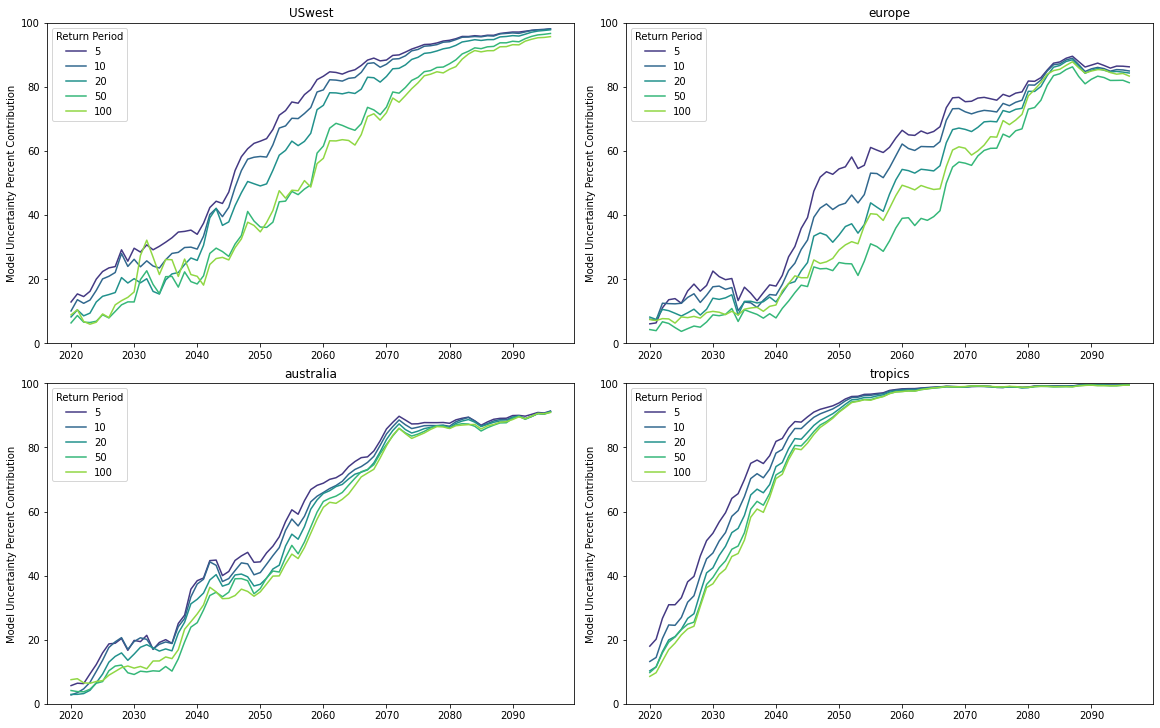

In [71]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("viridis", len(test_return.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_return.concat_dim):
        axe.plot(test_return.sel(region=r,concat_dim=m).time,test_return.sel(region=r,concat_dim=m).model_le_frac,
                c=colors[i])
        labels=['5','10','20','50','100']
        axe.legend(labels=labels,loc=2,title='Return Period')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,100)
        # print(i)
        # model_frac = test_return.sel(region=r).model_le_frac
        # model_frac.plot(hue='concat_dim',c=colors[i],ax=axe,add_legend=False)
        

For temp: greater internal variability for larger return periods. US west and Europe have largest spreads. Convergence towards the end of the century for all return periods when model uncertainty dominates. This point is reached much earlier for the tropics. 

### Hist_slice

In [34]:
test_histslice = sensitivity_allregions(parameter='hist_slice',
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'conseq_days':1,
                                                'rolling_average':10,
                                                'hist_slice':[slice('1920','1940'),slice('1960','1980'),
                                                              slice('1990','2010'),slice('1995','2014'),
                                                              slice(None, None), slice('1990', None)],
                                               'postprocess':False}
                                       )

In [35]:
test_histslice

<xarray.Dataset>
Dimensions:            (time: 86, member: 50, model: 4, concat_dim: 6, region: 4)
Coordinates:
  * time               (time) datetime64[ns] 2015-01-01 ... 2100-01-01
  * member             (member) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
    member_id          (model, member) object 'r16i1p2f1' 'r16i1p1f1' ... nan
  * model              (model) <U13 'CanESM5' 'cesm_lens' ... 'MPI-ESM1-2-LR'
    quantile           (concat_dim) float64 0.9997 0.9997 ... 0.9997 0.9997
  * concat_dim         (concat_dim) object slice('1920', '1940', None) ... sl...
  * region             (region) <U9 'USwest' 'europe' 'australia' 'tropics'
Data variables: (12/17)
    pr_occurance       (region, concat_dim, model, member, time) float64 nan ...
    model_le           (region, concat_dim, time) float64 nan nan ... nan nan
    internal_mean_le   (region, concat_dim, time) float64 nan nan ... nan nan
    internal_var_le    (region, concat_dim, time) float64 nan nan ... nan nan
    total_le           (region, concat_dim, time) float64 nan nan ... nan nan
    total_direct_le    (region, concat_dim, time) float64 nan nan ... nan nan
    ...                 ...
    model_fit          (region, concat_dim, time) float64 nan nan ... nan nan
    total_fit          (region, concat_dim, time) float64 nan nan ... nan nan
    internal_fit_frac  (region, concat_dim, time) float64 nan nan ... nan nan
    model_fit_frac     (region, concat_dim, time) float64 nan nan ... nan nan
    total_direct_fit   (region, concat_dim, time) float64 nan nan ... nan nan
    MTratio            (region, concat_dim, time) float64 nan nan ... nan nan

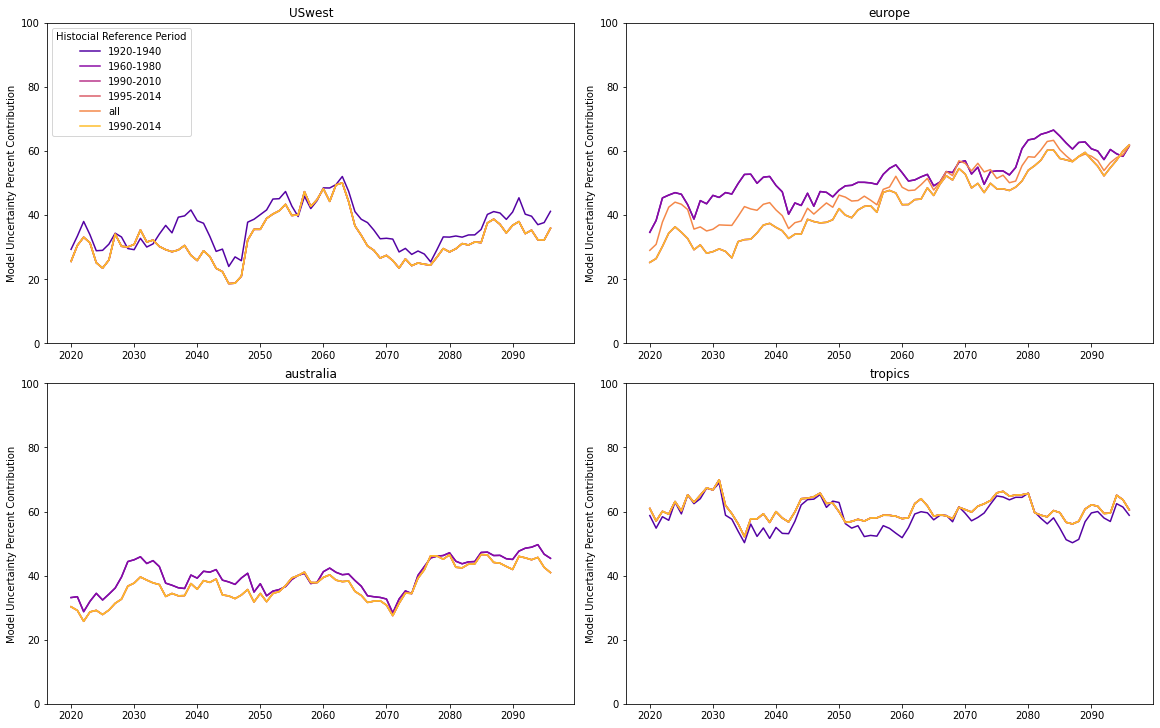

In [56]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("plasma", len(test_histslice.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i in range(len(test_histslice.concat_dim)):
        axe.plot(test_histslice.sel(region=r).isel(concat_dim=i).time,test_histslice.sel(region=r).isel(concat_dim=i).model_le_frac,
                c=colors[i])
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,100)
labels = ['1920-1940','1960-1980','1990-2010','1995-2014','all','1990-2014']
ax[0,0].legend(labels=labels,loc=2,title='Histocial Reference Period')

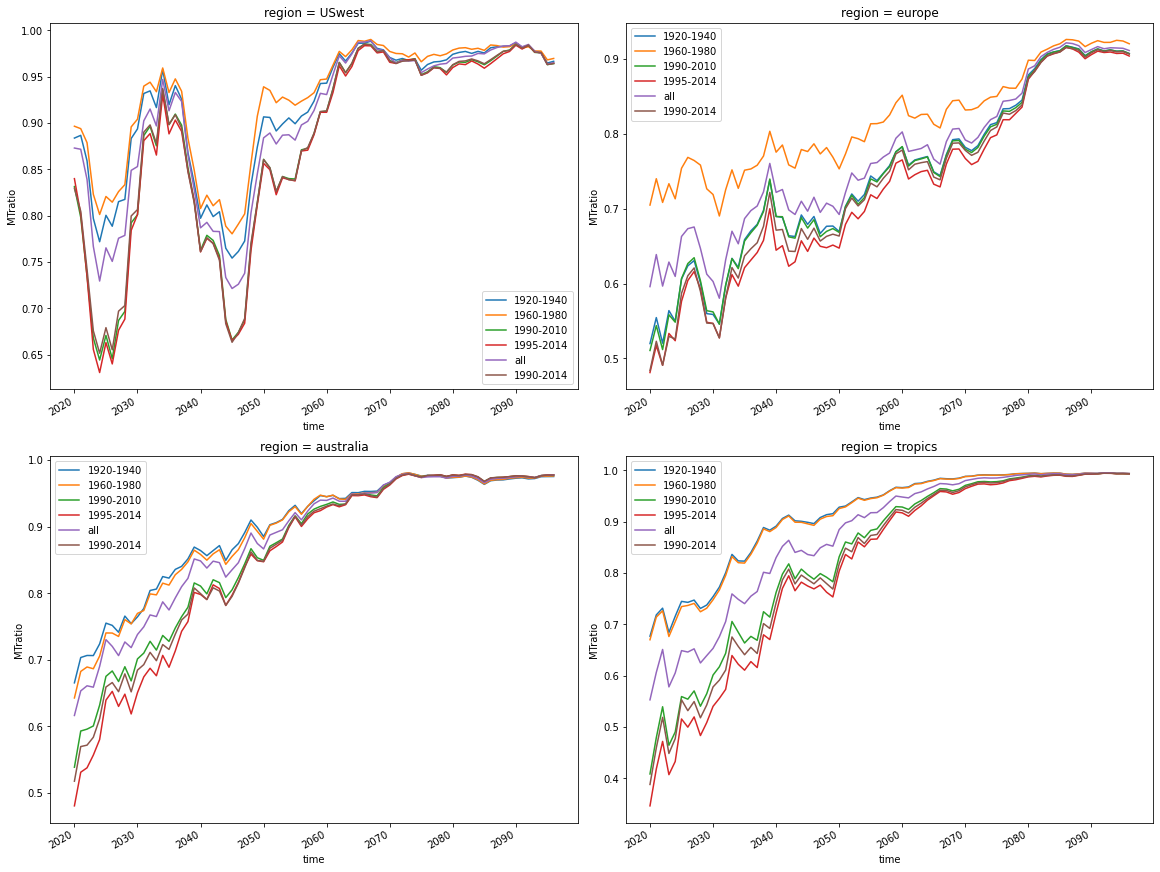

In [34]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,12))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    test_histslice.sel(region=r).MTratio.plot(hue='concat_dim',ax=axe,add_legend=False);
    labels = ['1920-1940','1960-1980','1990-2010','1995-2014','all','1990-2014']
    axe.legend(labels)

### coarsen

In [72]:
test_coarsen = sensitivity_allregions(parameter='coarsen',
                                    args = {'return_period':10,
                                            'coarsen':[1,3,5,7],
                                            'conseq_days':1,
                                            'rolling_average':10,
                                            'hist_slice':slice('1995','2014'),
                                            'postprocess':True
                                           })

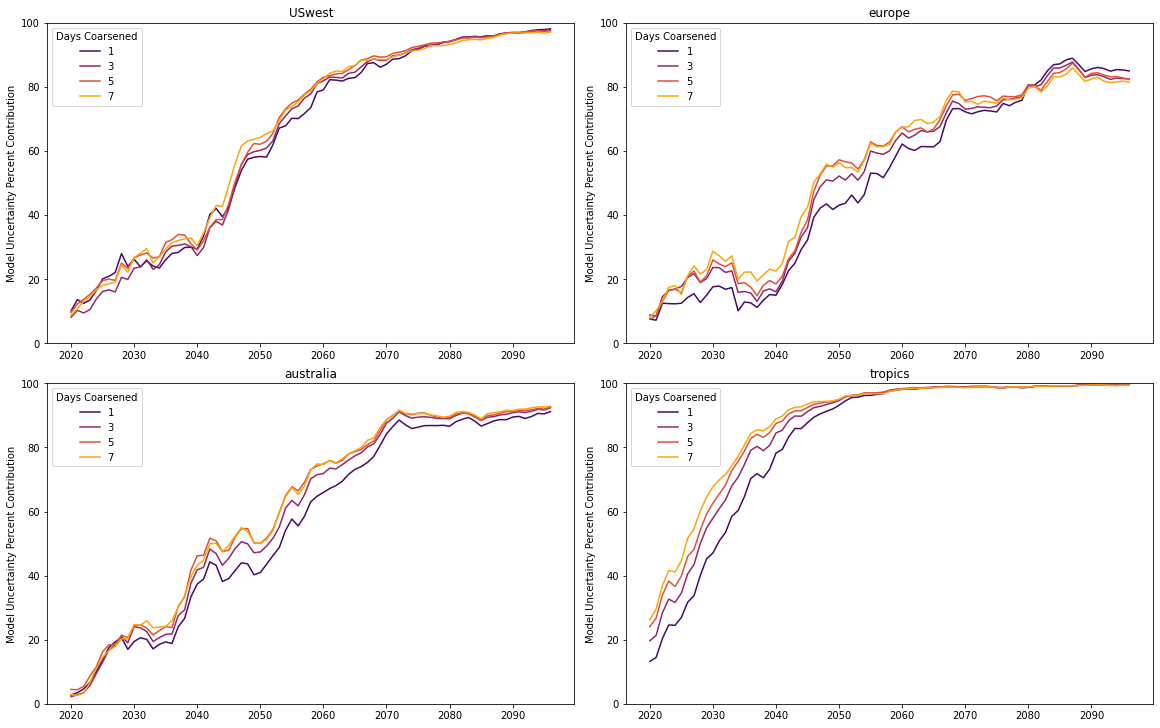

In [74]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("inferno", len(test_coarsen.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_coarsen.concat_dim):
        axe.plot(test_coarsen.sel(region=r,concat_dim=m).time,test_coarsen.sel(region=r,concat_dim=m).model_le_frac,
                c=colors[i])
        labels=['1','3','5','7']
        axe.legend(labels=labels,loc=2,title='Days Coarsened')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,100)
        # print(i)
        # model_frac = test_return.sel(region=r).model_le_frac
        # model_frac.plot(hue='concat_dim',c=colors[i],ax=axe,add_legend=False)
        

### Consecutive days 

In [84]:
test_conseq = sensitivity_allregions(parameter='conseq_days',
                       args= {'return_period':10,
                              'coarsen':1,
                              'conseq_days':[1,3,5,7],
                              'rolling_average':10,
                              'hist_slice':slice('1995','2014'),
                              'postprocess':True
                             }
                      )

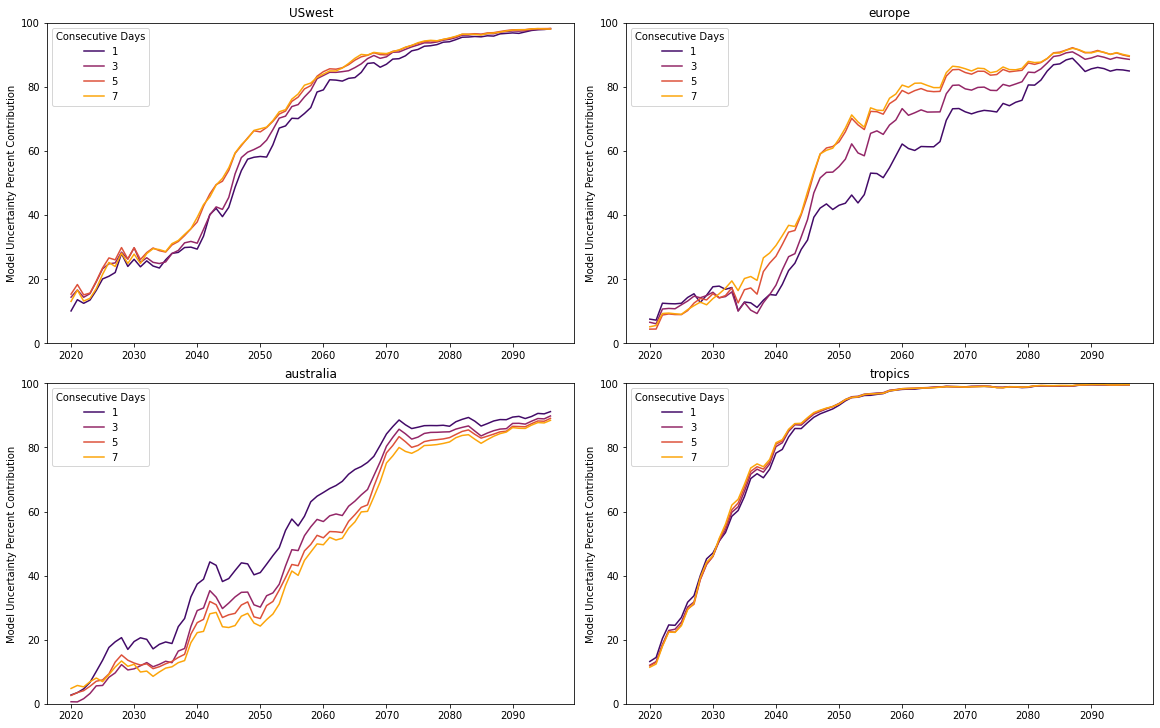

In [77]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("inferno", len(test_conseq.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_conseq.concat_dim):
        axe.plot(test_conseq.sel(region=r,concat_dim=m).time,test_conseq.sel(region=r,concat_dim=m).model_le_frac,
                c=colors[i])
        labels=['1','3','5','7']
        axe.legend(labels=labels,loc=2,title='Consecutive Days')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,100)
        # print(i)
        # model_frac = test_return.sel(region=r).model_le_frac
        # model_frac.plot(hue='concat_dim',c=colors[i],ax=axe,add_legend=False)

#### coarsen / consec combo

In [97]:
test_conseq = extreme_internal_allregions(
                       args= {'return_period':10,
                              'coarsen':3,
                              'conseq_days':7,
                              'rolling_average':10,
                              'hist_slice':slice('1995','2014'),
                              'postprocess':True
                             }
                      )

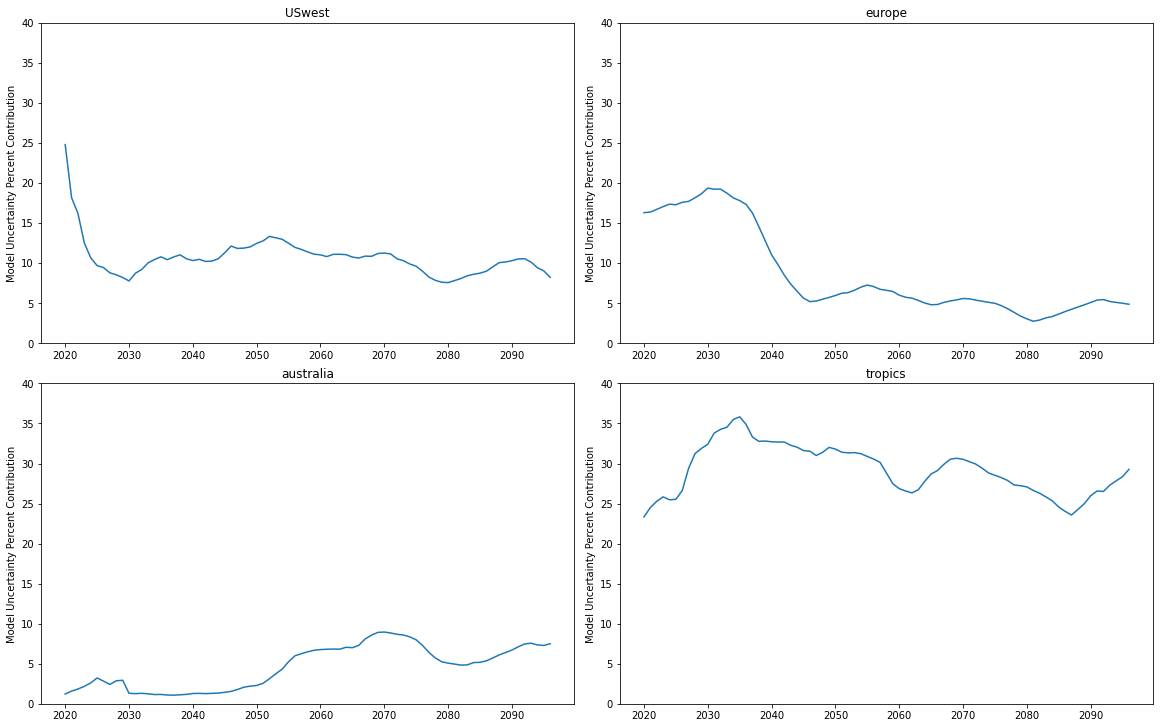

In [99]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
# colors = sns.color_palette("inferno", len(test_conseq.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    axe.plot(test_conseq.sel(region=r).time,test_conseq.sel(region=r).model_le_frac)
        # axe.legend(labels=labels,loc=2,title='Consecutive Days')
    axe.set_ylabel('Model Uncertainty Percent Contribution')
    axe.set_title(r)
    axe.set_ylim(0,40)
        # print(i)
        # model_frac = test_return.sel(region=r).model_le_frac
        # model_frac.plot(hue='concat_dim',c=colors[i],ax=axe,add_legend=False)

### rolling average

In [78]:
test_rolling = sensitivity_allregions(parameter='rolling_average',
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'conseq_days':1,
                                                'rolling_average':[1,5,10,15,20],
                                                'hist_slice':slice('1995','2014'),
                                                'postprocess':True
                                               }
                                     )

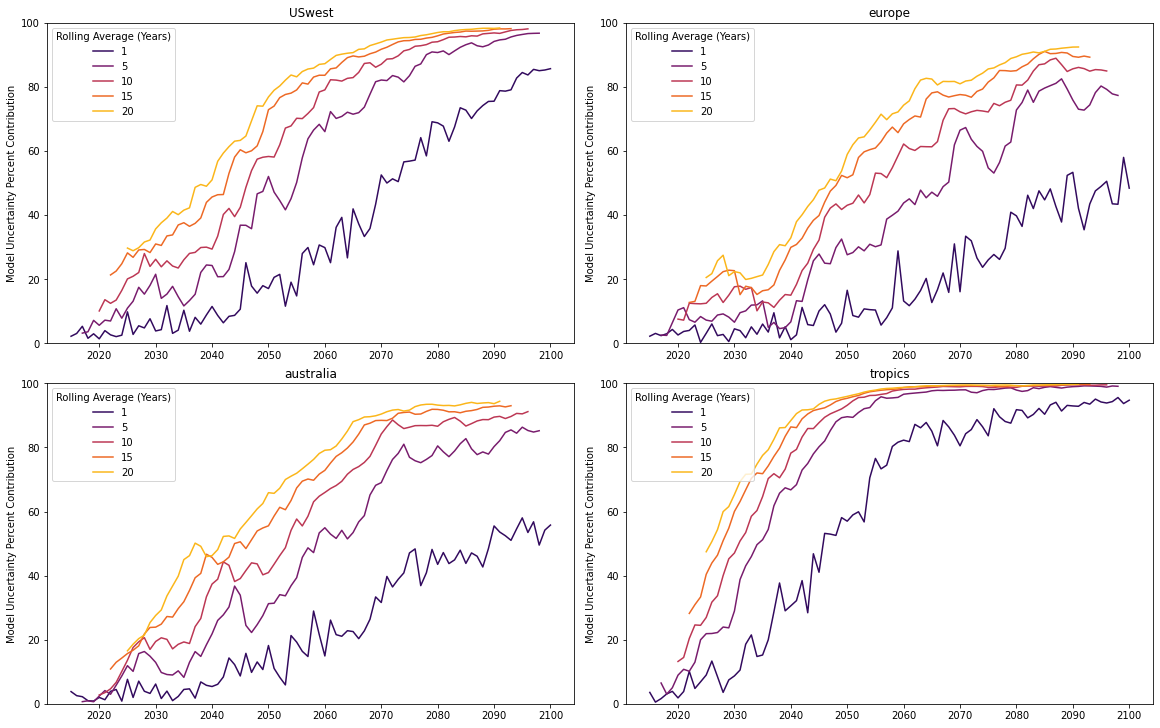

In [80]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("inferno", len(test_rolling.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_rolling.concat_dim):
        axe.plot(test_rolling.sel(region=r,concat_dim=m).time,test_rolling.sel(region=r,concat_dim=m).model_le_frac,
                c=colors[i])
        labels=['1','5','10','15','20']
        axe.legend(labels=labels,loc=2,title='Rolling Average (Years)')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,100)
        # print(i)
        # model_frac = test_return.sel(region=r).model_le_frac
        # model_frac.plot(hue='concat_dim',c=colors[i],ax=axe,add_legend=False)